In [1]:
from warnings import filterwarnings
filterwarnings('ignore')
import numpy as np
import pandas as pd
import os
import json

# Web Virtual Beach 
## conceptual demonstration
Presented by Douglas Patton*
### building and validating predictive models
### small datasets
#### Douglas Patton\*, Mike Cyterski, Deron Smith, Kurt Wolfe, Brandon Main\*, Jason Duncan\*, John Johnston
\* Orise Participant


*This research was supported in part by an appointment to the ORISE Fellowship Program at the U.S. EPA, Office of Research and Development, Athens, GA, administered by the Oak Ridge Institute for Science and Education through Interagency Agreement No. DW8992298301 between the U.S. Department of Energy and the U.S. Environmental Protection Agency.*

In [2]:
kwargs=dict(
    shuffle=True,
    drop_duplicates='Xy',#'X',False
    nan_threshold=0.9,#drop any column with more than this share of nulls
    run_stacked=True, 
    test_share=0,
    cv_folds=5,
    cv_reps=10,
    cv_strategy=None,
    )

from vb_helper import VBHelper
vbhelper=VBHelper(**kwargs)

no daal4py


In [3]:
scorer_list=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'] #strings defined in scikit-learn
vbhelper.scorer_list=scorer_list

In [4]:
#load data
data_path=os.path.join('sample_data','ex1.csv')
df=pd.read_csv(data_path)

#select variables
y_name='THG_Fish'
loc_vars=['LAT','LONG']
drop_vars=['Date','OrigHabCode','STA_ID']
drop_vars.extend(loc_vars)
drop_vars.append(y_name)
all_vars=list(df.columns)
x_vars=[var for var in all_vars if var not in drop_vars]

#extract random rows for prediction
predict_n=3
shuf=np.arange(df.shape[0])
seed=0
rng = np.random.default_rng(seed)
rng.shuffle(shuf)
predict_select=shuf[:predict_n]
X_predict=df.loc[:,x_vars].iloc[predict_select]
y_predict=df.loc[:,y_name].iloc[predict_select]
df.drop(index=predict_select,inplace=True)
X_df=df.loc[:,x_vars]
y_df=df.loc[:,[y_name]]
print(f'indices for predictions: {X_predict.index.to_list()}')

indices for predictions: [420, 652, 575]


# VB web
### load a dataset
dimensions of X:

In [5]:
X_df.shape

(771, 45)

dimensions of y:

In [6]:
y_df.shape

(771, 1)

#### import the data and check for duplicates

In [7]:
vbhelper.setData(X_df,y_df)

# of duplicate rows of data: 0
# of duplicate rows of X: 0
# of duplicate Xy rows dropped: 0
no columns exceeded nan threshold of 0.9


# VB web
### Take a look at the data

#### export the data to json to mimic front-end/back-end network communication

In [8]:
vbhelper.saveFullFloatXy()

In [9]:
from vb_summary import VBSummary
vbs=VBSummary()

with open('summaryXy.json','r') as f:
    data_for_summary=json.load(f)
    
vbs.setData(data_for_summary)

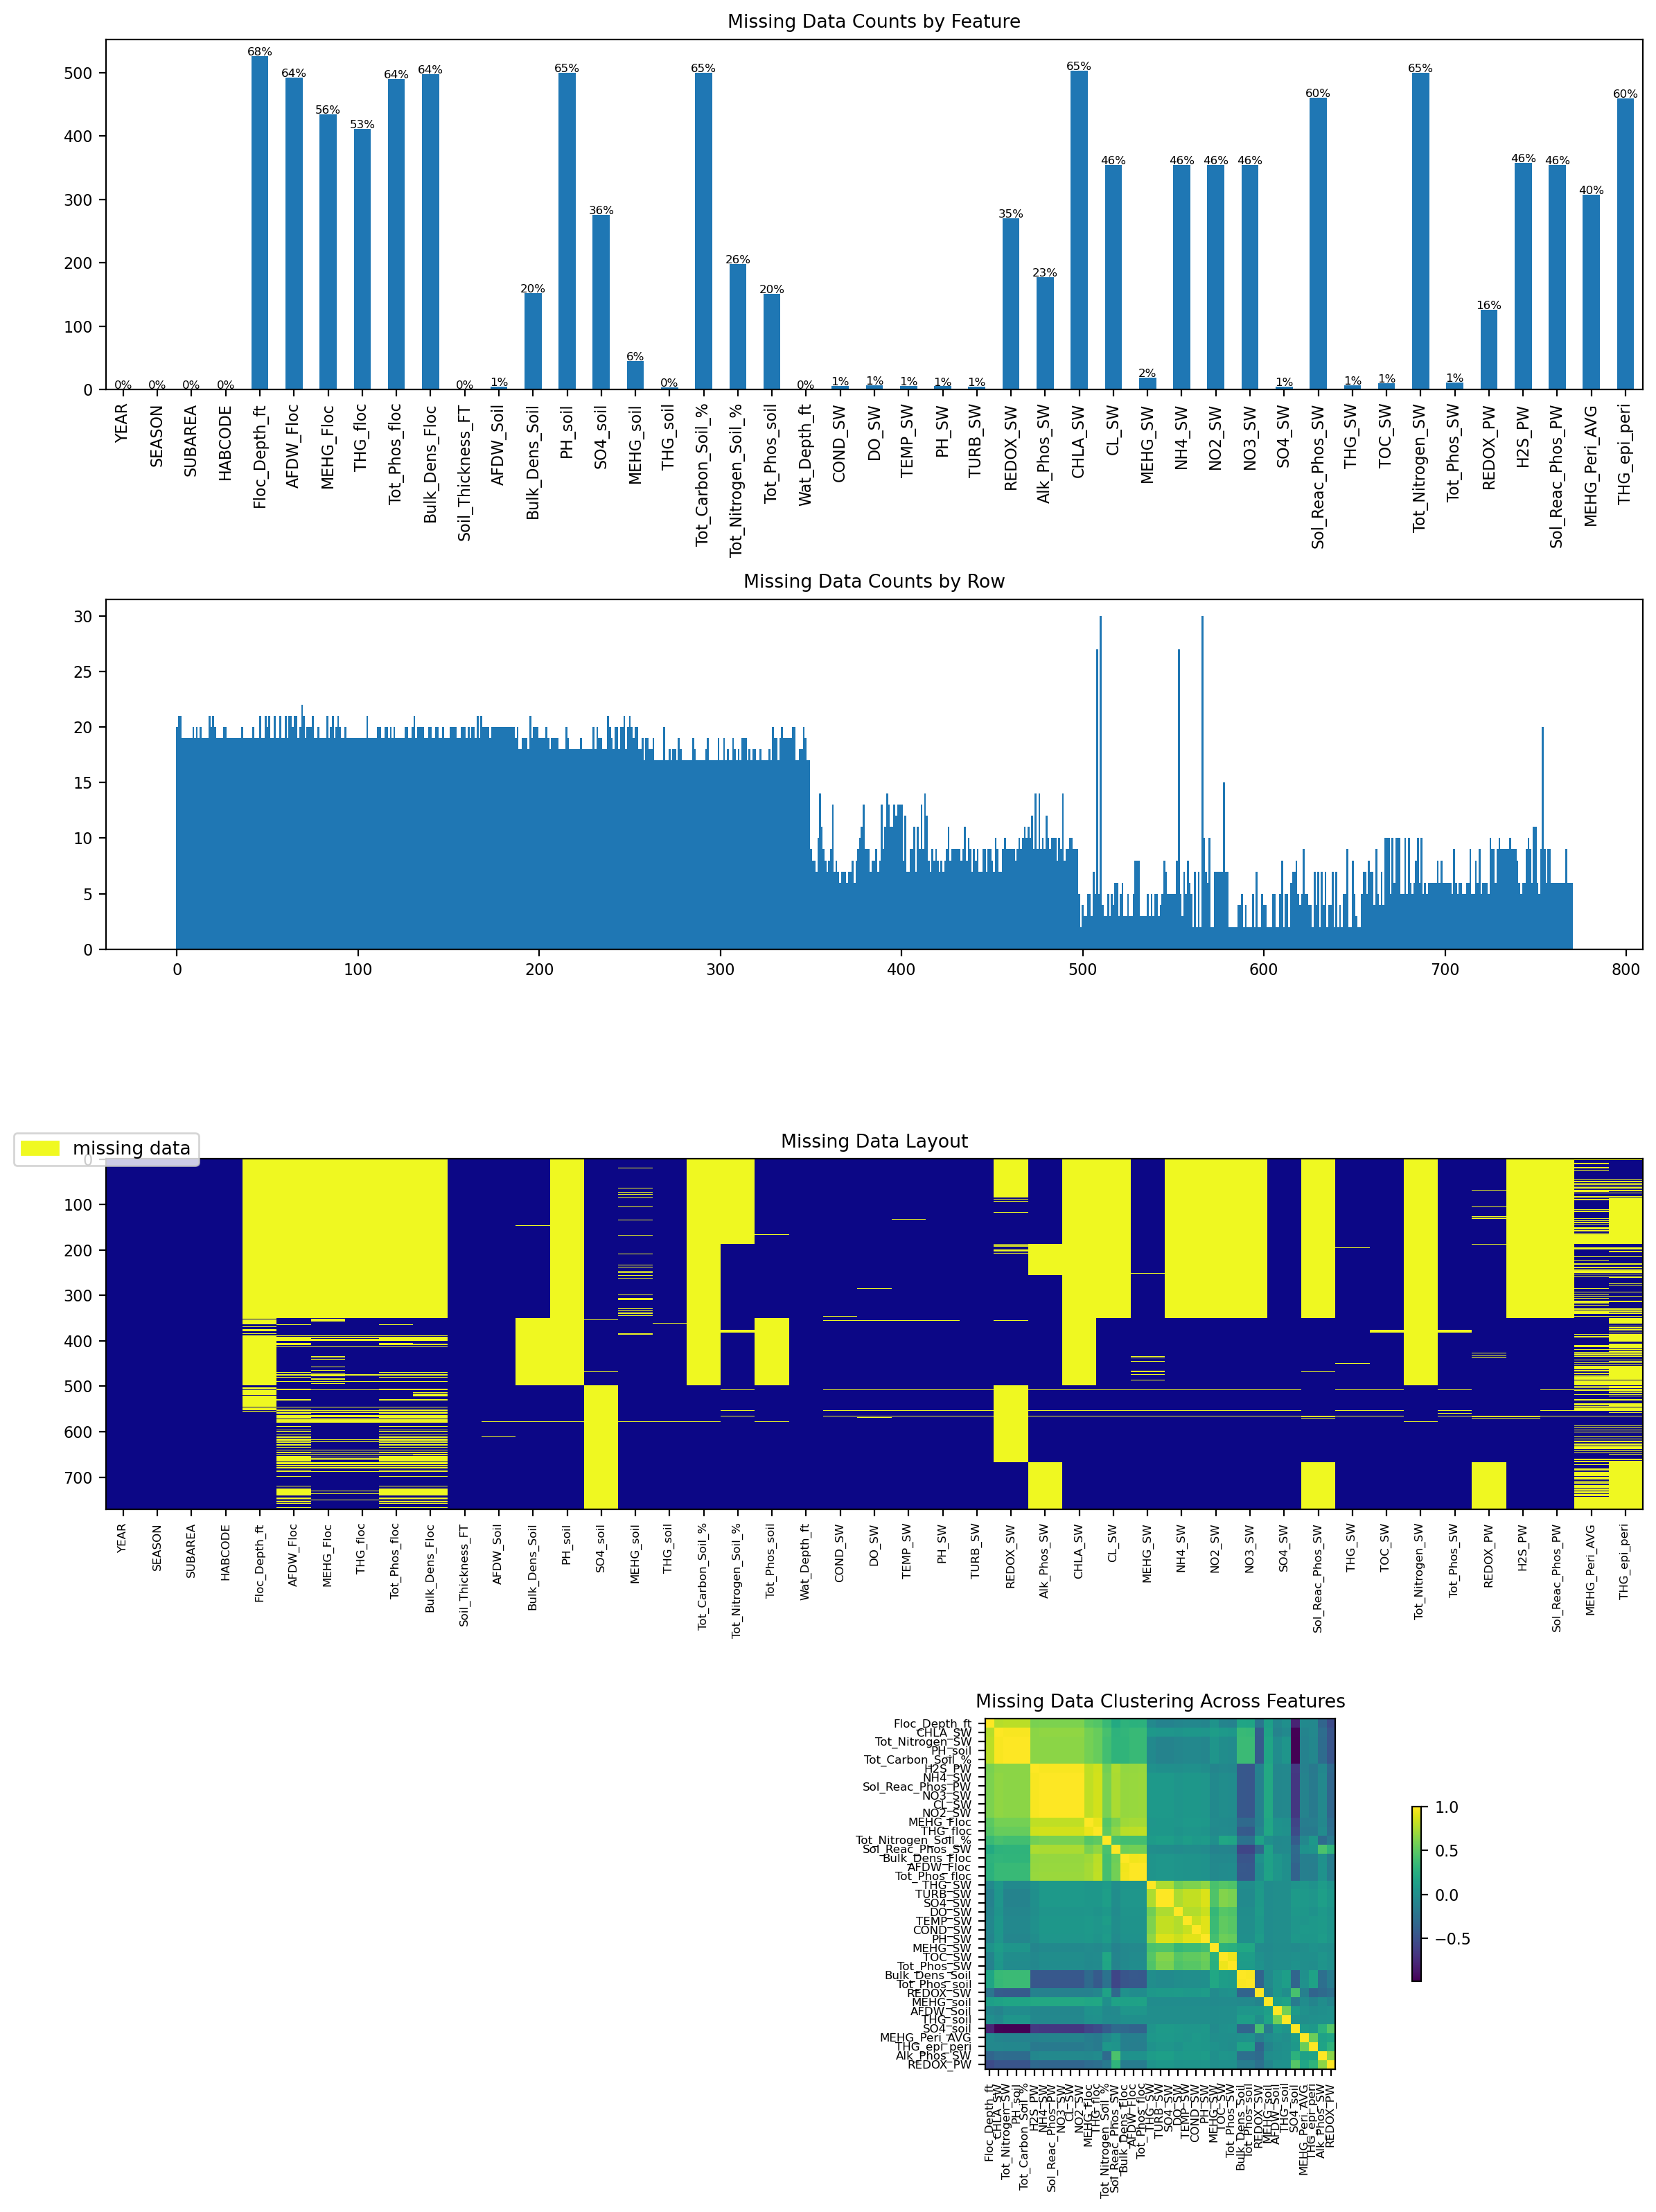

In [10]:
vbs.missingVals()

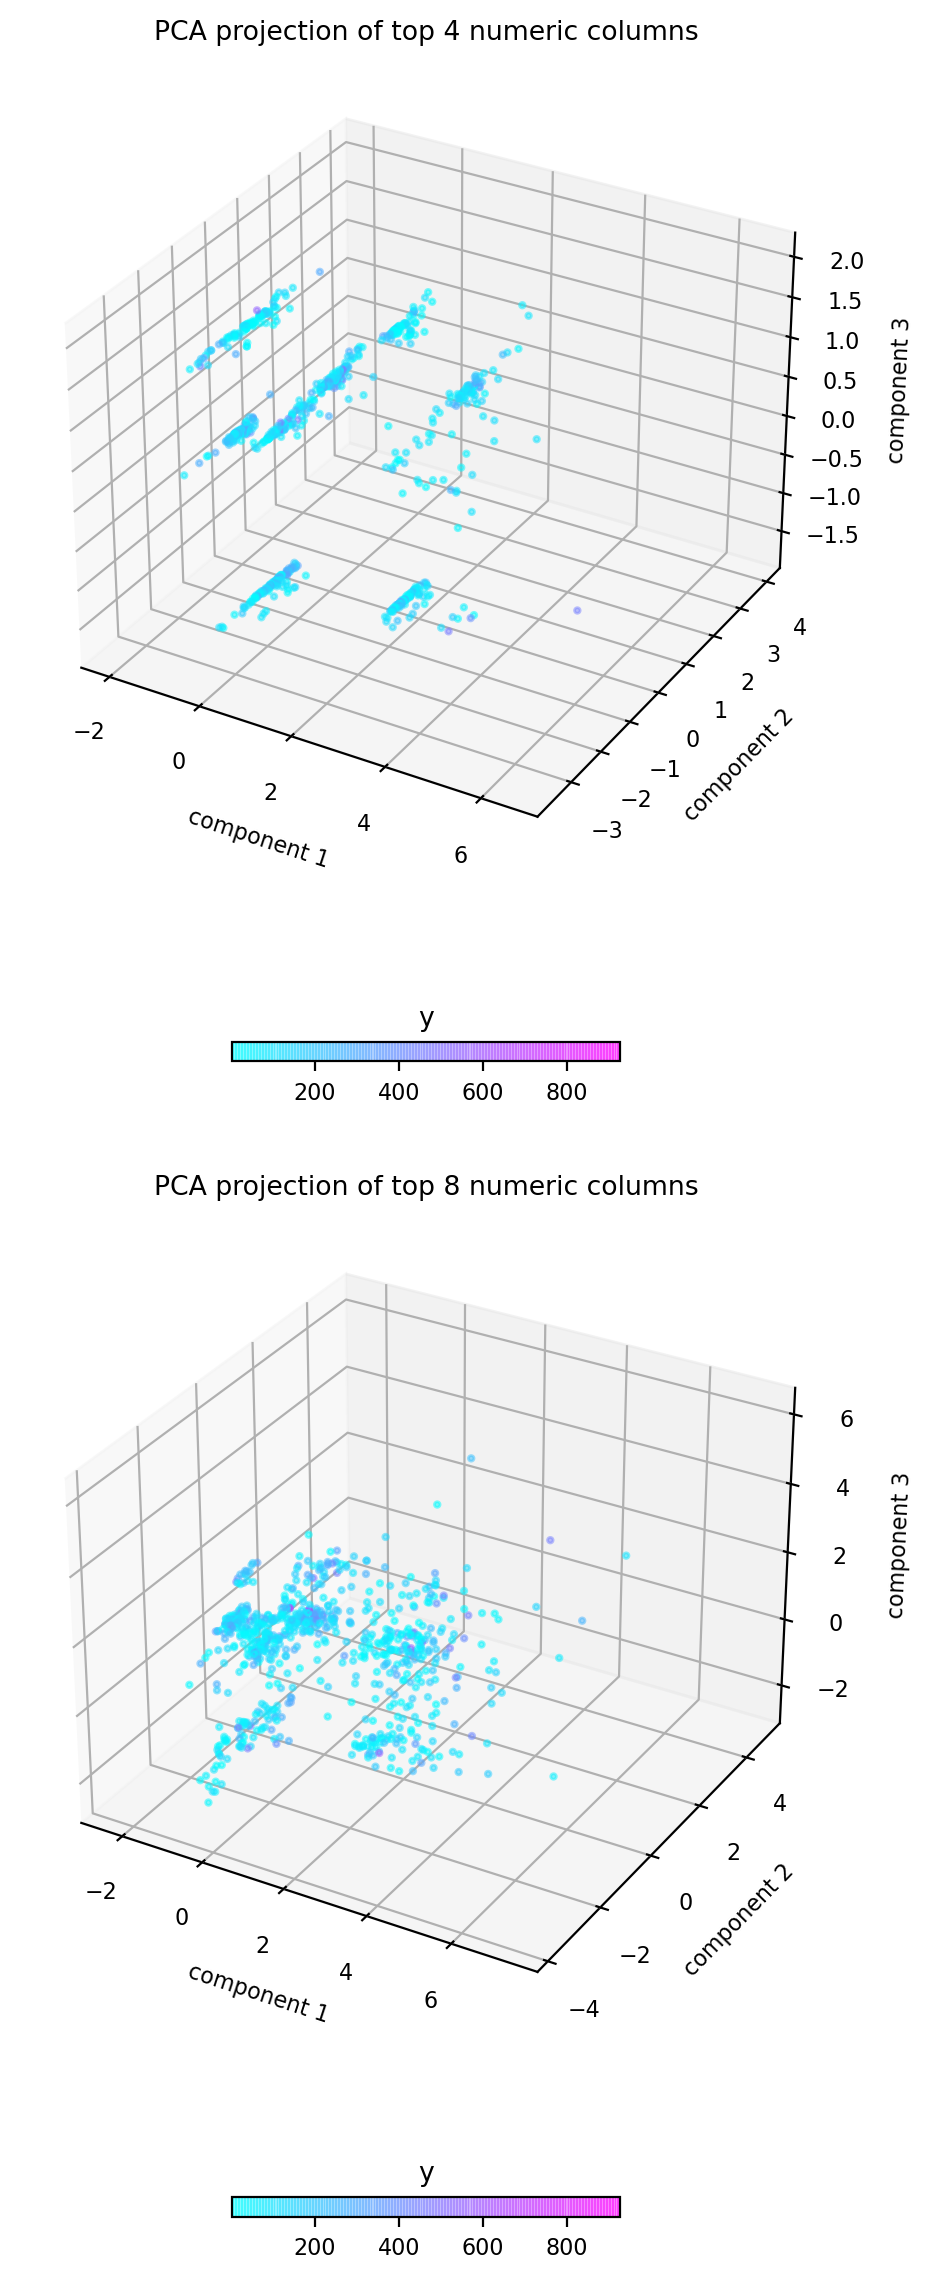

In [11]:
vbs.viewComponents(num_cols=[4,8],keep_cats=False)

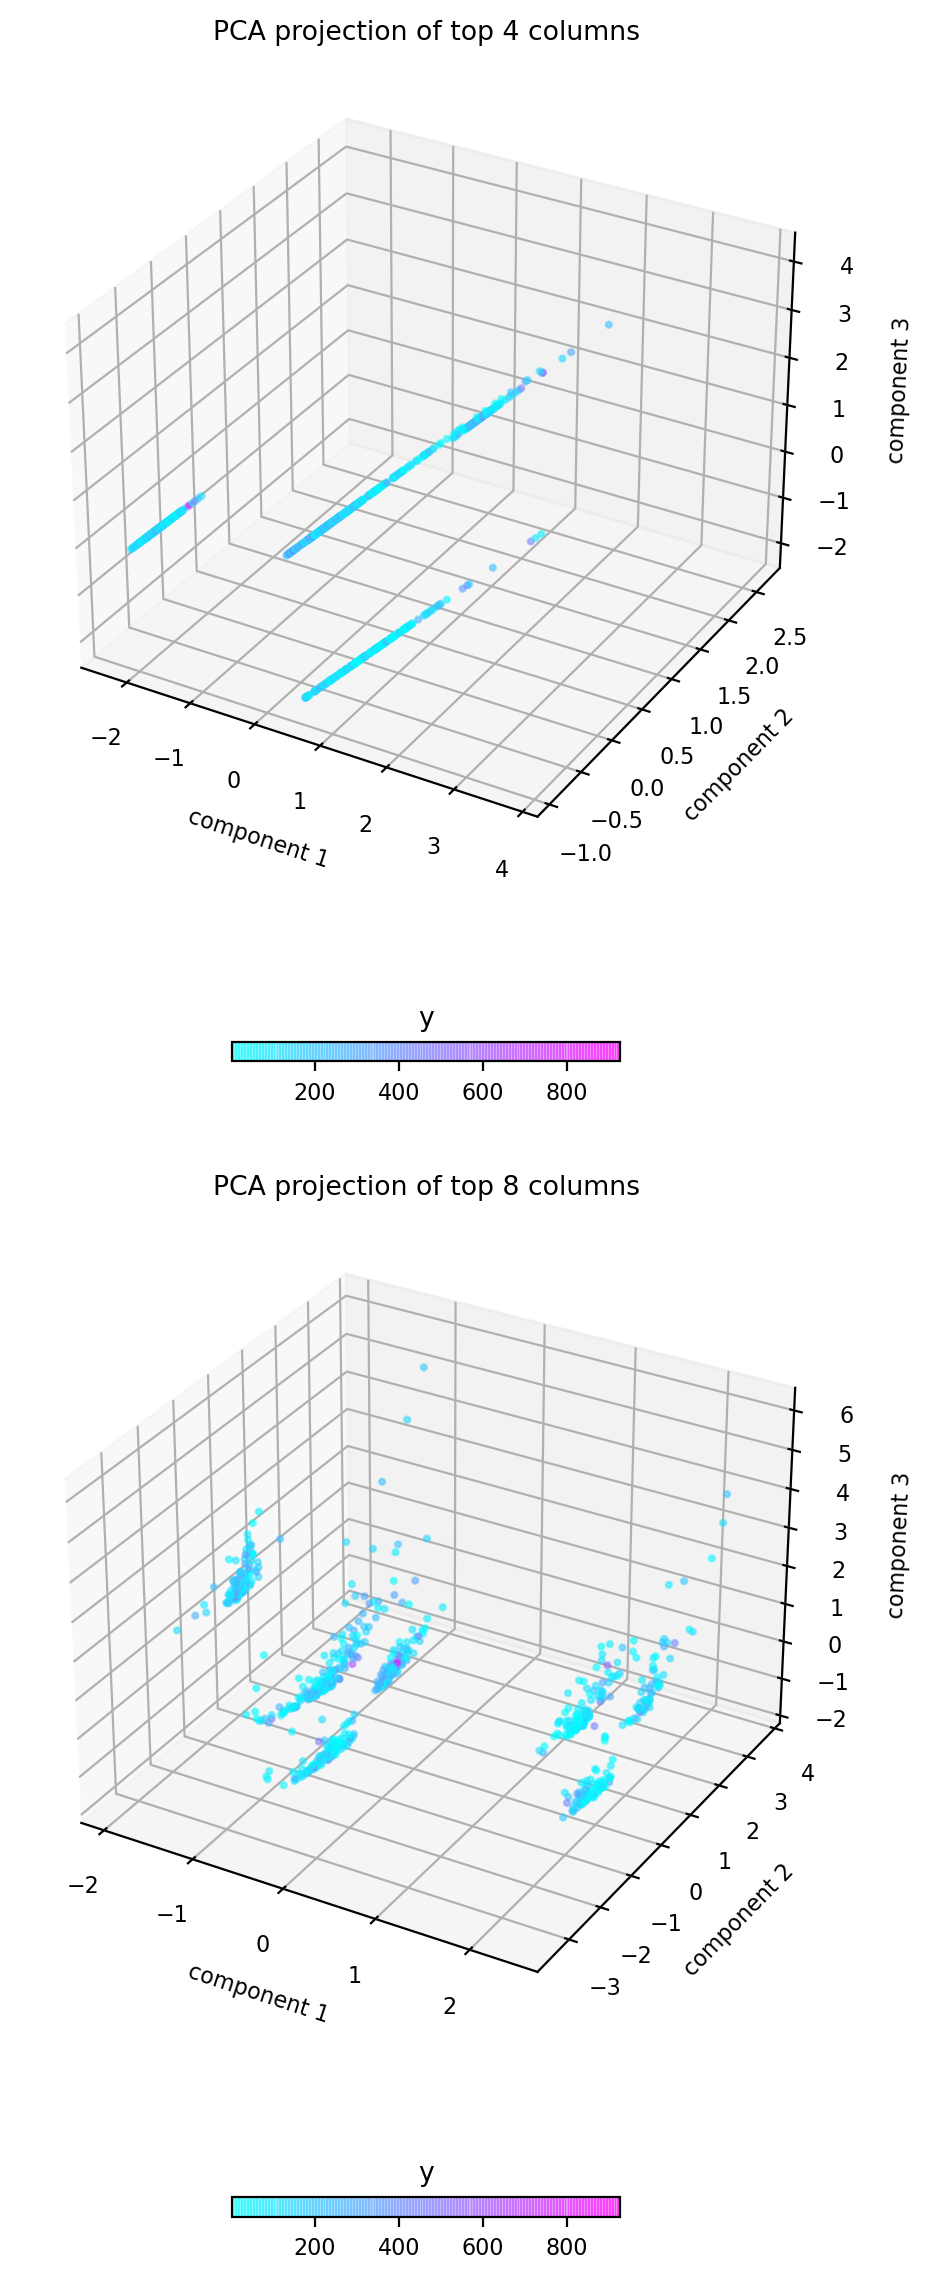

In [12]:
vbs.viewComponents(num_cols=[4,8],keep_cats=True)

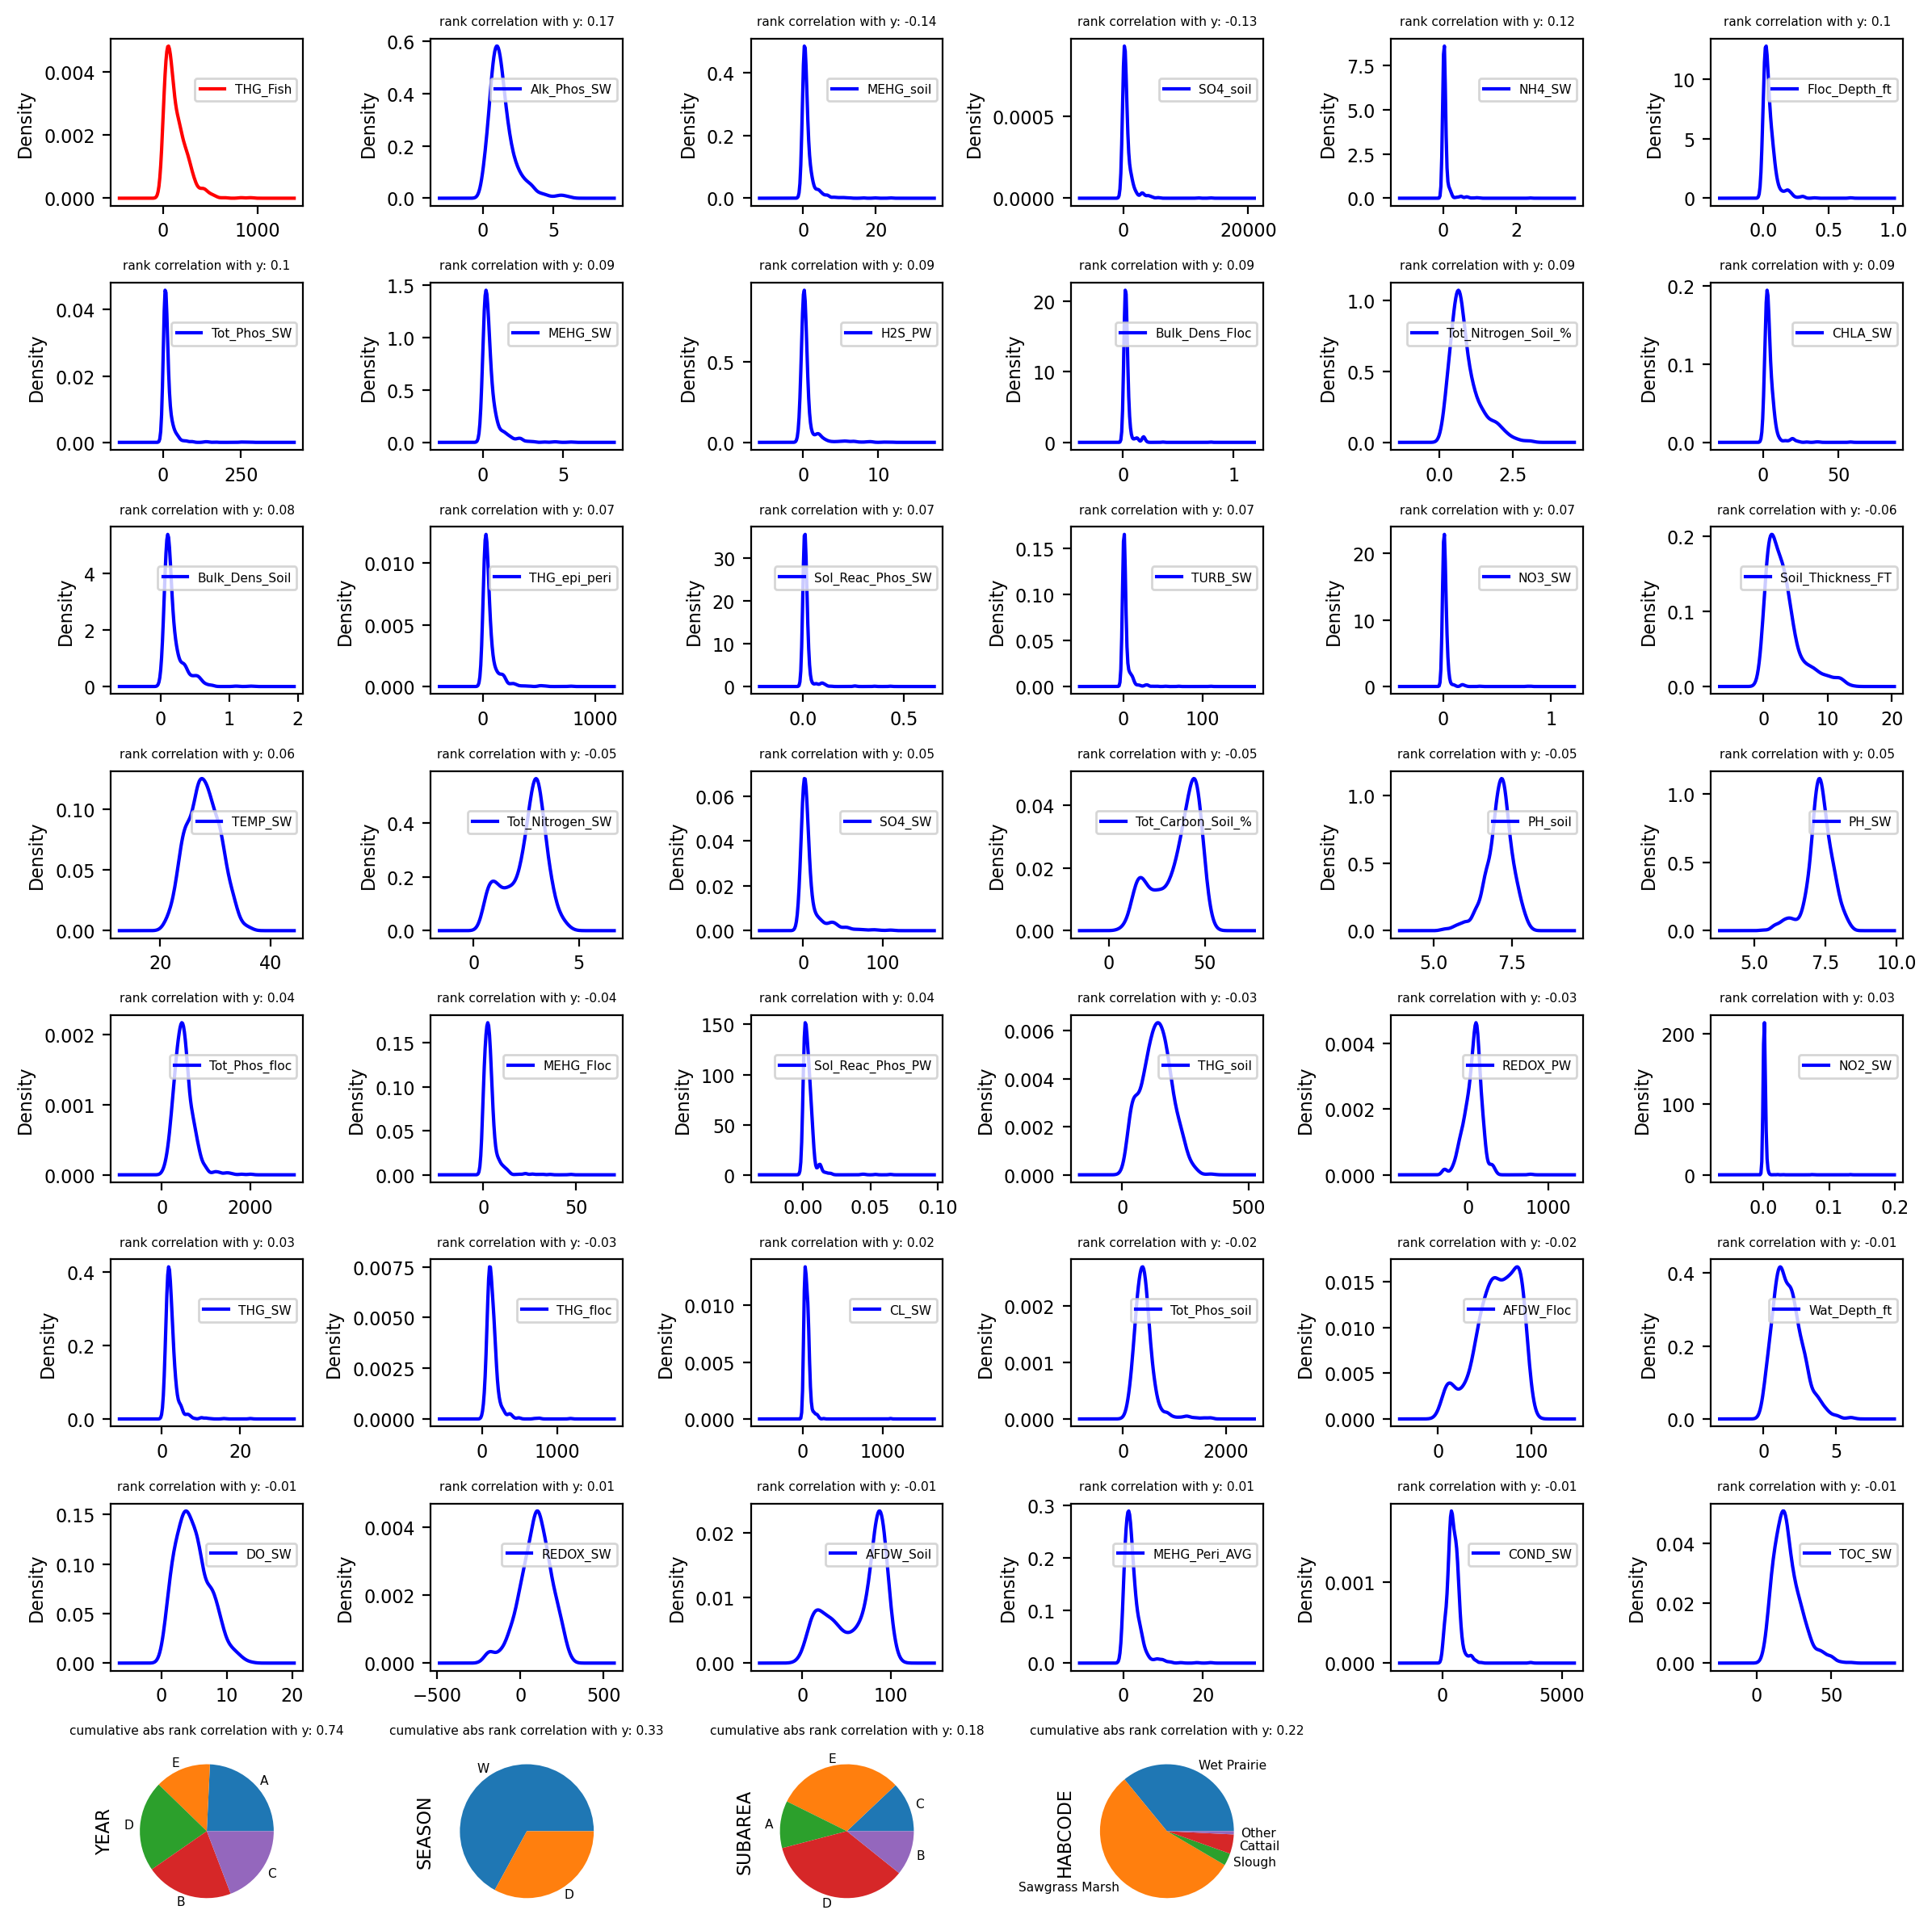

In [13]:
vbs.kernelDensityPie()

In [14]:
#vbs.hierarchicalDendrogram(linkage='ward',dist='pearsonr')

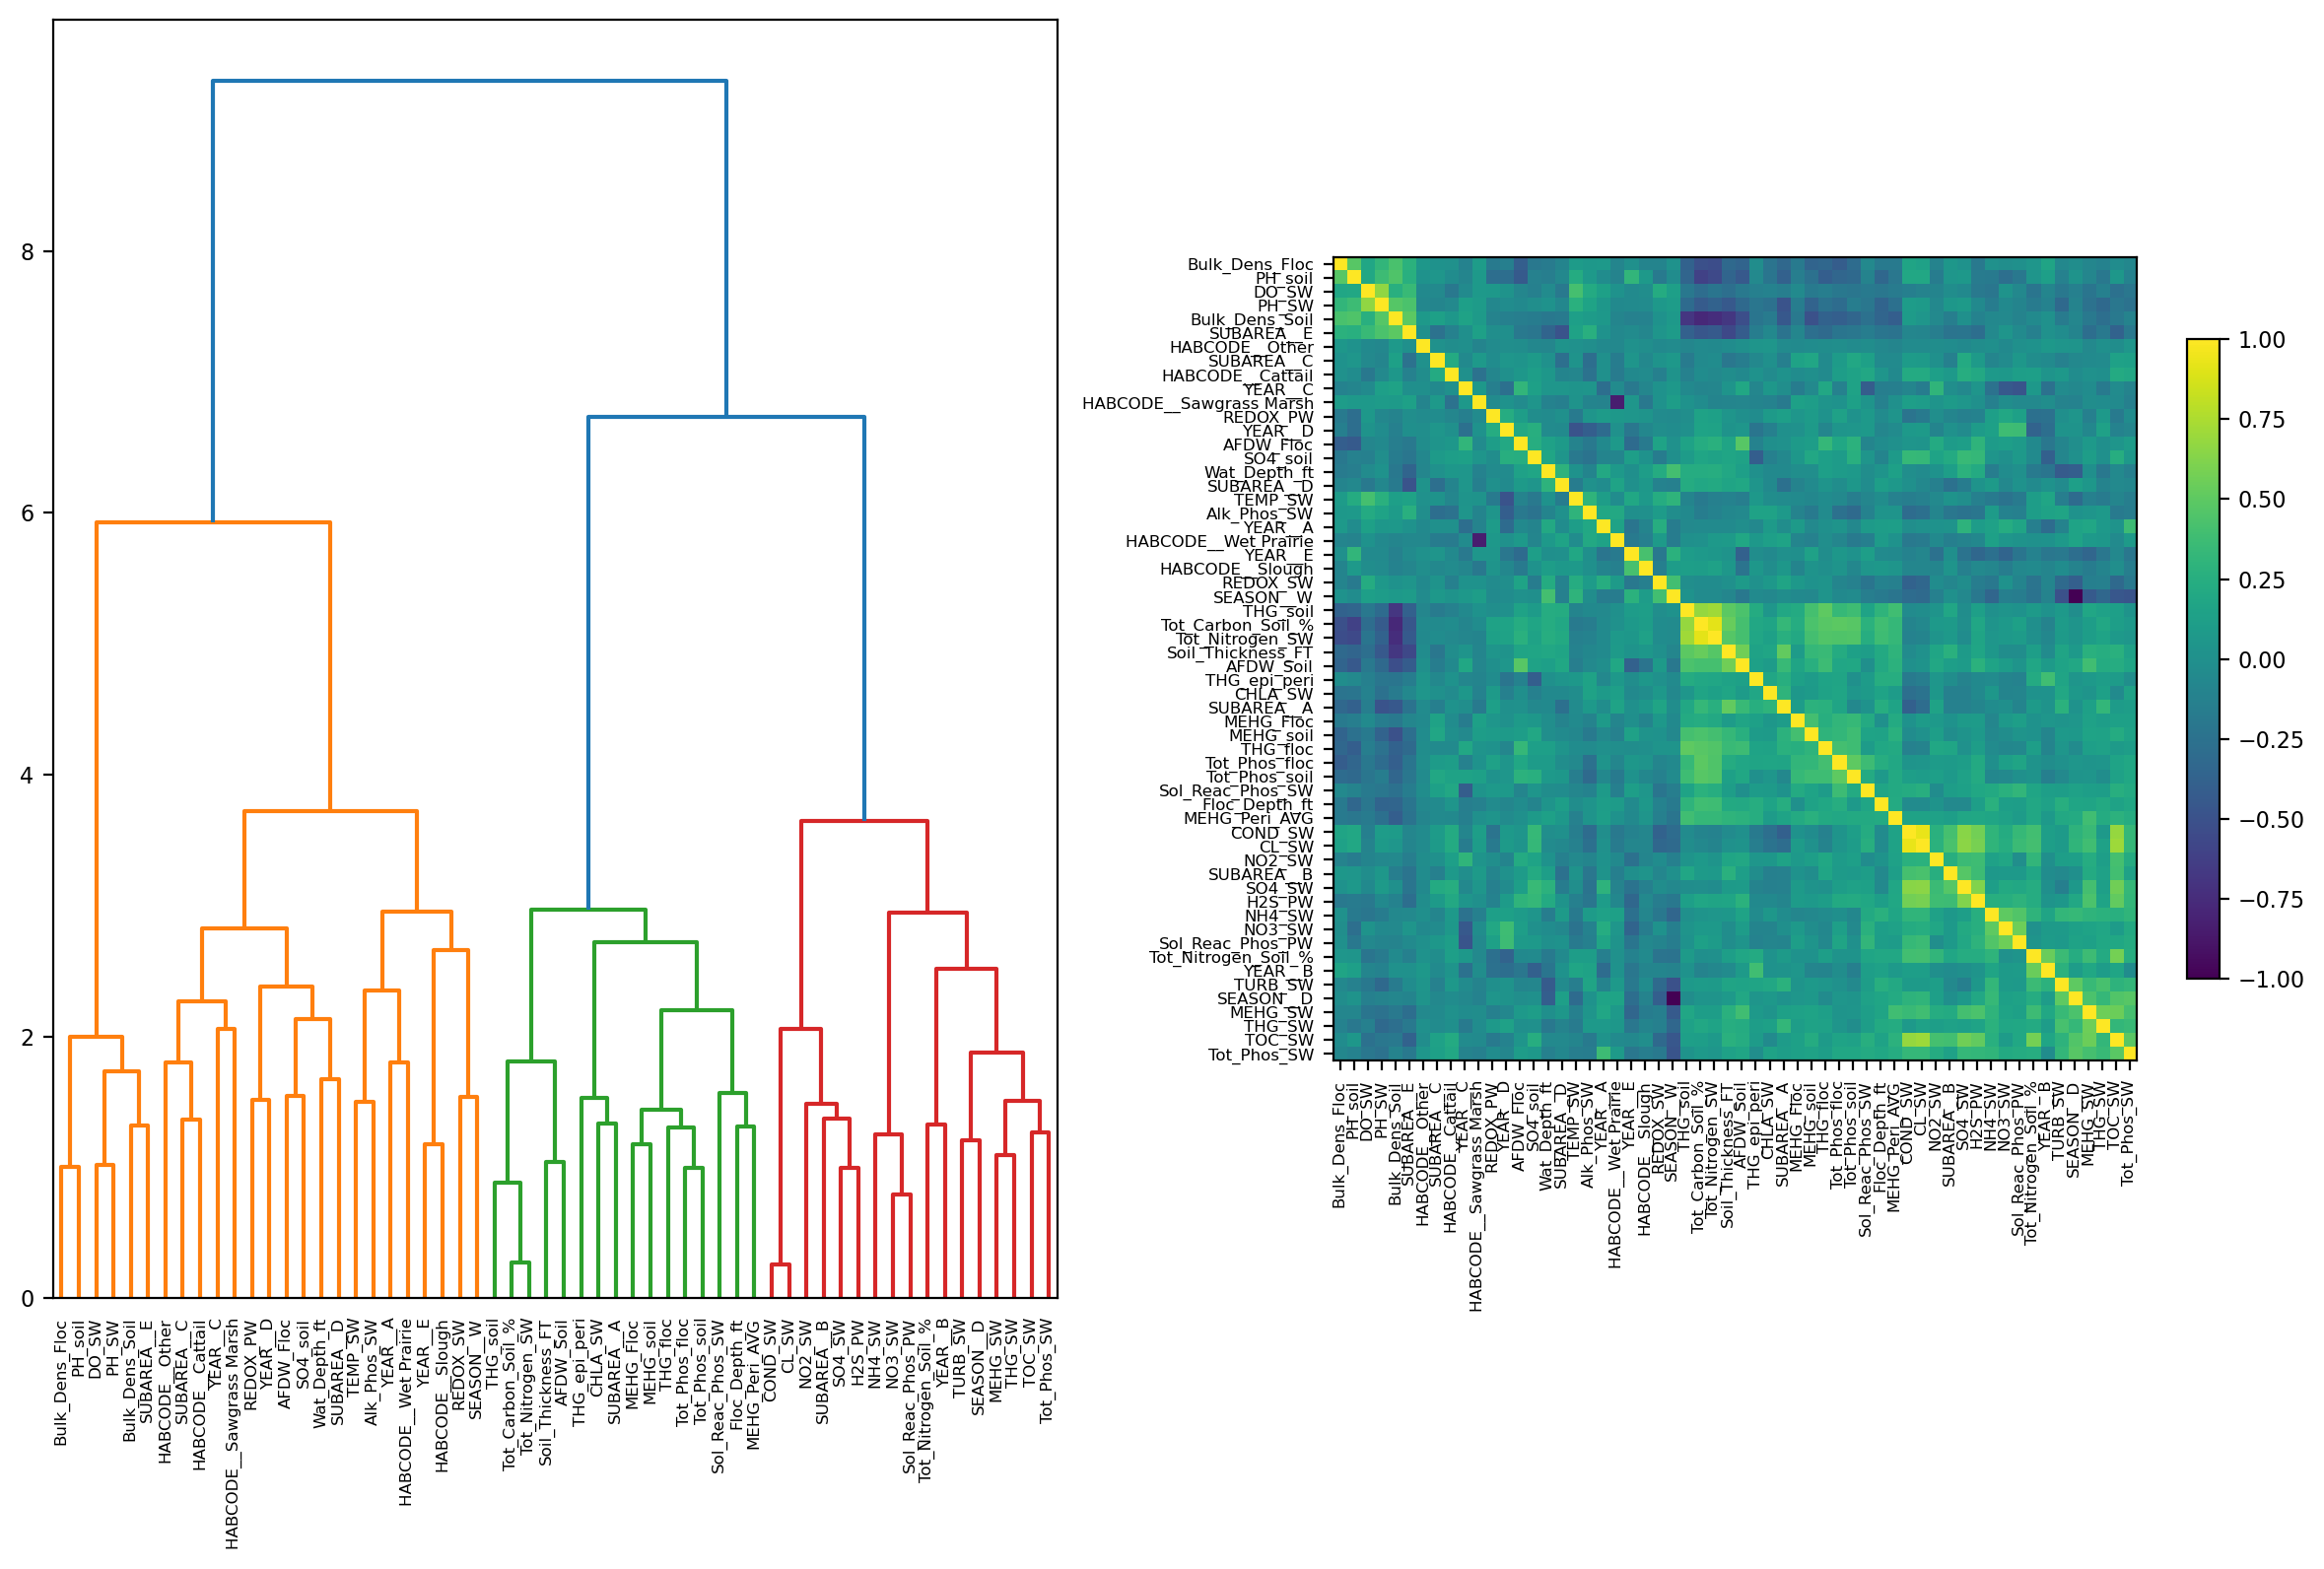

In [15]:
vbs.hierarchicalDendrogram(linkage='ward',dist='spearmanr')

# VB web
### Machine Learning Pipelines

#### What is a pipeline?


#### Life as a Pipeline

- A. Preparation
  1. Imputation (KNN or Mean)
  2. Categoric to Numeric Data
- B. Feature Engineering
  1. Drop Zero Variance
  2. Drop Useless (PCA or LASSO)
  3. Create Interactions
  4. Drop Useless (PCA or LASSO)
- C. Estimation
  - e.g., Linear Regression or Gradient Boosting or Support Vector or Stacked

![pipeline schematic](images/pipeline_anatomy.jpg)

![pipeline schematic](images/life_stages_detail.jpg)

#### specify internal CV for hyper-parameter tuning

In [16]:
inner_cv_dict={
    'cv_reps':1,
    'cv_folds':5,
    'cv_strategy':('quantile',5)} # ensure each fold has y values from each quantile
inner_cv=vbhelper.getCV(cv_dict=inner_cv_dict)

#### specify data preparation

In [17]:
prep_dict={
    'cat_approach':'together', # imputation is over all variables after one-hot-encoding
    'impute_strategy':'IterativeImputer', # python implementation of MICE: Multivariate Imputation by Chained Equations in R”
    'cat_idx':vbhelper.cat_idx # keep track of the categorical variables
    }
pipe_dict={} # the pipeline setup will go here

#### specify pipelines

##### setup keyword arguments for pipelines

In [18]:
pipe_kwargs={
    'do_prep':not vbhelper.run_stacked, # the stacking regressor will do imputation if run_stacked==False
    'prep_dict':prep_dict,
    'inner_cv':inner_cv,
    'cat_idx':vbhelper.cat_idx,
    'float_idx':vbhelper.float_idx,
    'bestT':False # if true, test each covariate for optimal transformation 
    }

##### and a gradient boosting regressor pipeline


In [20]:
from vb_estimators import GBR

gbr_kwargs=pipe_kwargs.copy()
gbr_kwargs['est_kwargs']={
    'n_estimators':[64,128],
    'max_depth':[2,3]
    }
pipe_dict['gbr']={
    'pipe':GBR,
    'pipe_kwargs':gbr_kwargs
    }

##### create a cross-validated lasso linear regression pipeline

In [19]:
from vb_estimators import  L1Lars

l1_kwargs=pipe_kwargs.copy()
l1_kwargs['max_n_alphas']=500 # alpha is the only hyper-parameter
pipe_dict['lassolars']={
    'pipe':L1Lars,
    'pipe_kwargs':l1_kwargs
    }

##### and a support vector machine regressor using the rbf kernel

In [21]:
from vb_estimators import RBFSVR

rbf_kwargs=pipe_kwargs.copy()
rbf_kwargs['gridpoints']=5 
pipe_dict['rbfSVR']={
    'pipe':RBFSVR,
    'pipe_kwargs':rbf_kwargs
    }

and finally add a pipeline that tests a few non-linear models

In [22]:
from vb_estimators import FlexiblePipe

nl_pipe_kwargs=pipe_kwargs.copy()
nl_pipe_kwargs['functional_form_search']=True
nl_pipe_kwargs['flex_kwargs']={'robust':True}
pipe_dict['nonlinear']={
    'pipe':FlexiblePipe,
    'pipe_kwargs':nl_pipe_kwargs
}

In [23]:
#and load the pipelines
vbhelper.setPipeDict(pipe_dict)
vbhelper.setModelDict()

In [24]:
from sklearn.model_selection import train_test_split
from time import time
X_train, X_test, y_train, y_test=train_test_split(X_df,y_df,test_size=0.7,random_state=5) #just for debugging

In [25]:
runtest=False
if runtest:
    for name,est in vbhelper.model_dict.items():
        start=time()
        print(name)
        est.fit(X_train,y_train)
        print('train R2:',est.score(X_train,y_train))
        if not X_test is None:print('test R2:',est.score(X_test,y_test))
        end=time()
        print(f'runtime:{(end-start)/60} min.\n')

In [26]:
if vbhelper.run_stacked and runtest:
    mp=vbhelper.model_dict['multi_pipe']
    fitted_ipipe_dict=mp.build_individual_fitted_pipelines()
    for p_name,p in fitted_ipipe_dict.items():
        print(f'{p_name} scored: {p.score(X_test,y_test)}')


# VB web
### Small Data Procedure
---
#### task 1: evaluate the machine learning pipelines

In [27]:
vbhelper.runCrossValidate(try_load=True)

jhash:  440b67c5c80a529ac01daadb3cc5ef12
existing cv_results loaded


In [28]:
vbhelper.buildCVScoreDict()
vbhelper.saveCVResults()

saved to project_cv_results.json


### Plot the results

In [29]:
from vb_plotter import VBPlotter
plotter=VBPlotter()

with open('project_cv_results.json','rb') as f:
    cv_results_and_scores=json.load(f)
plotter.setData(cv_results_and_scores)

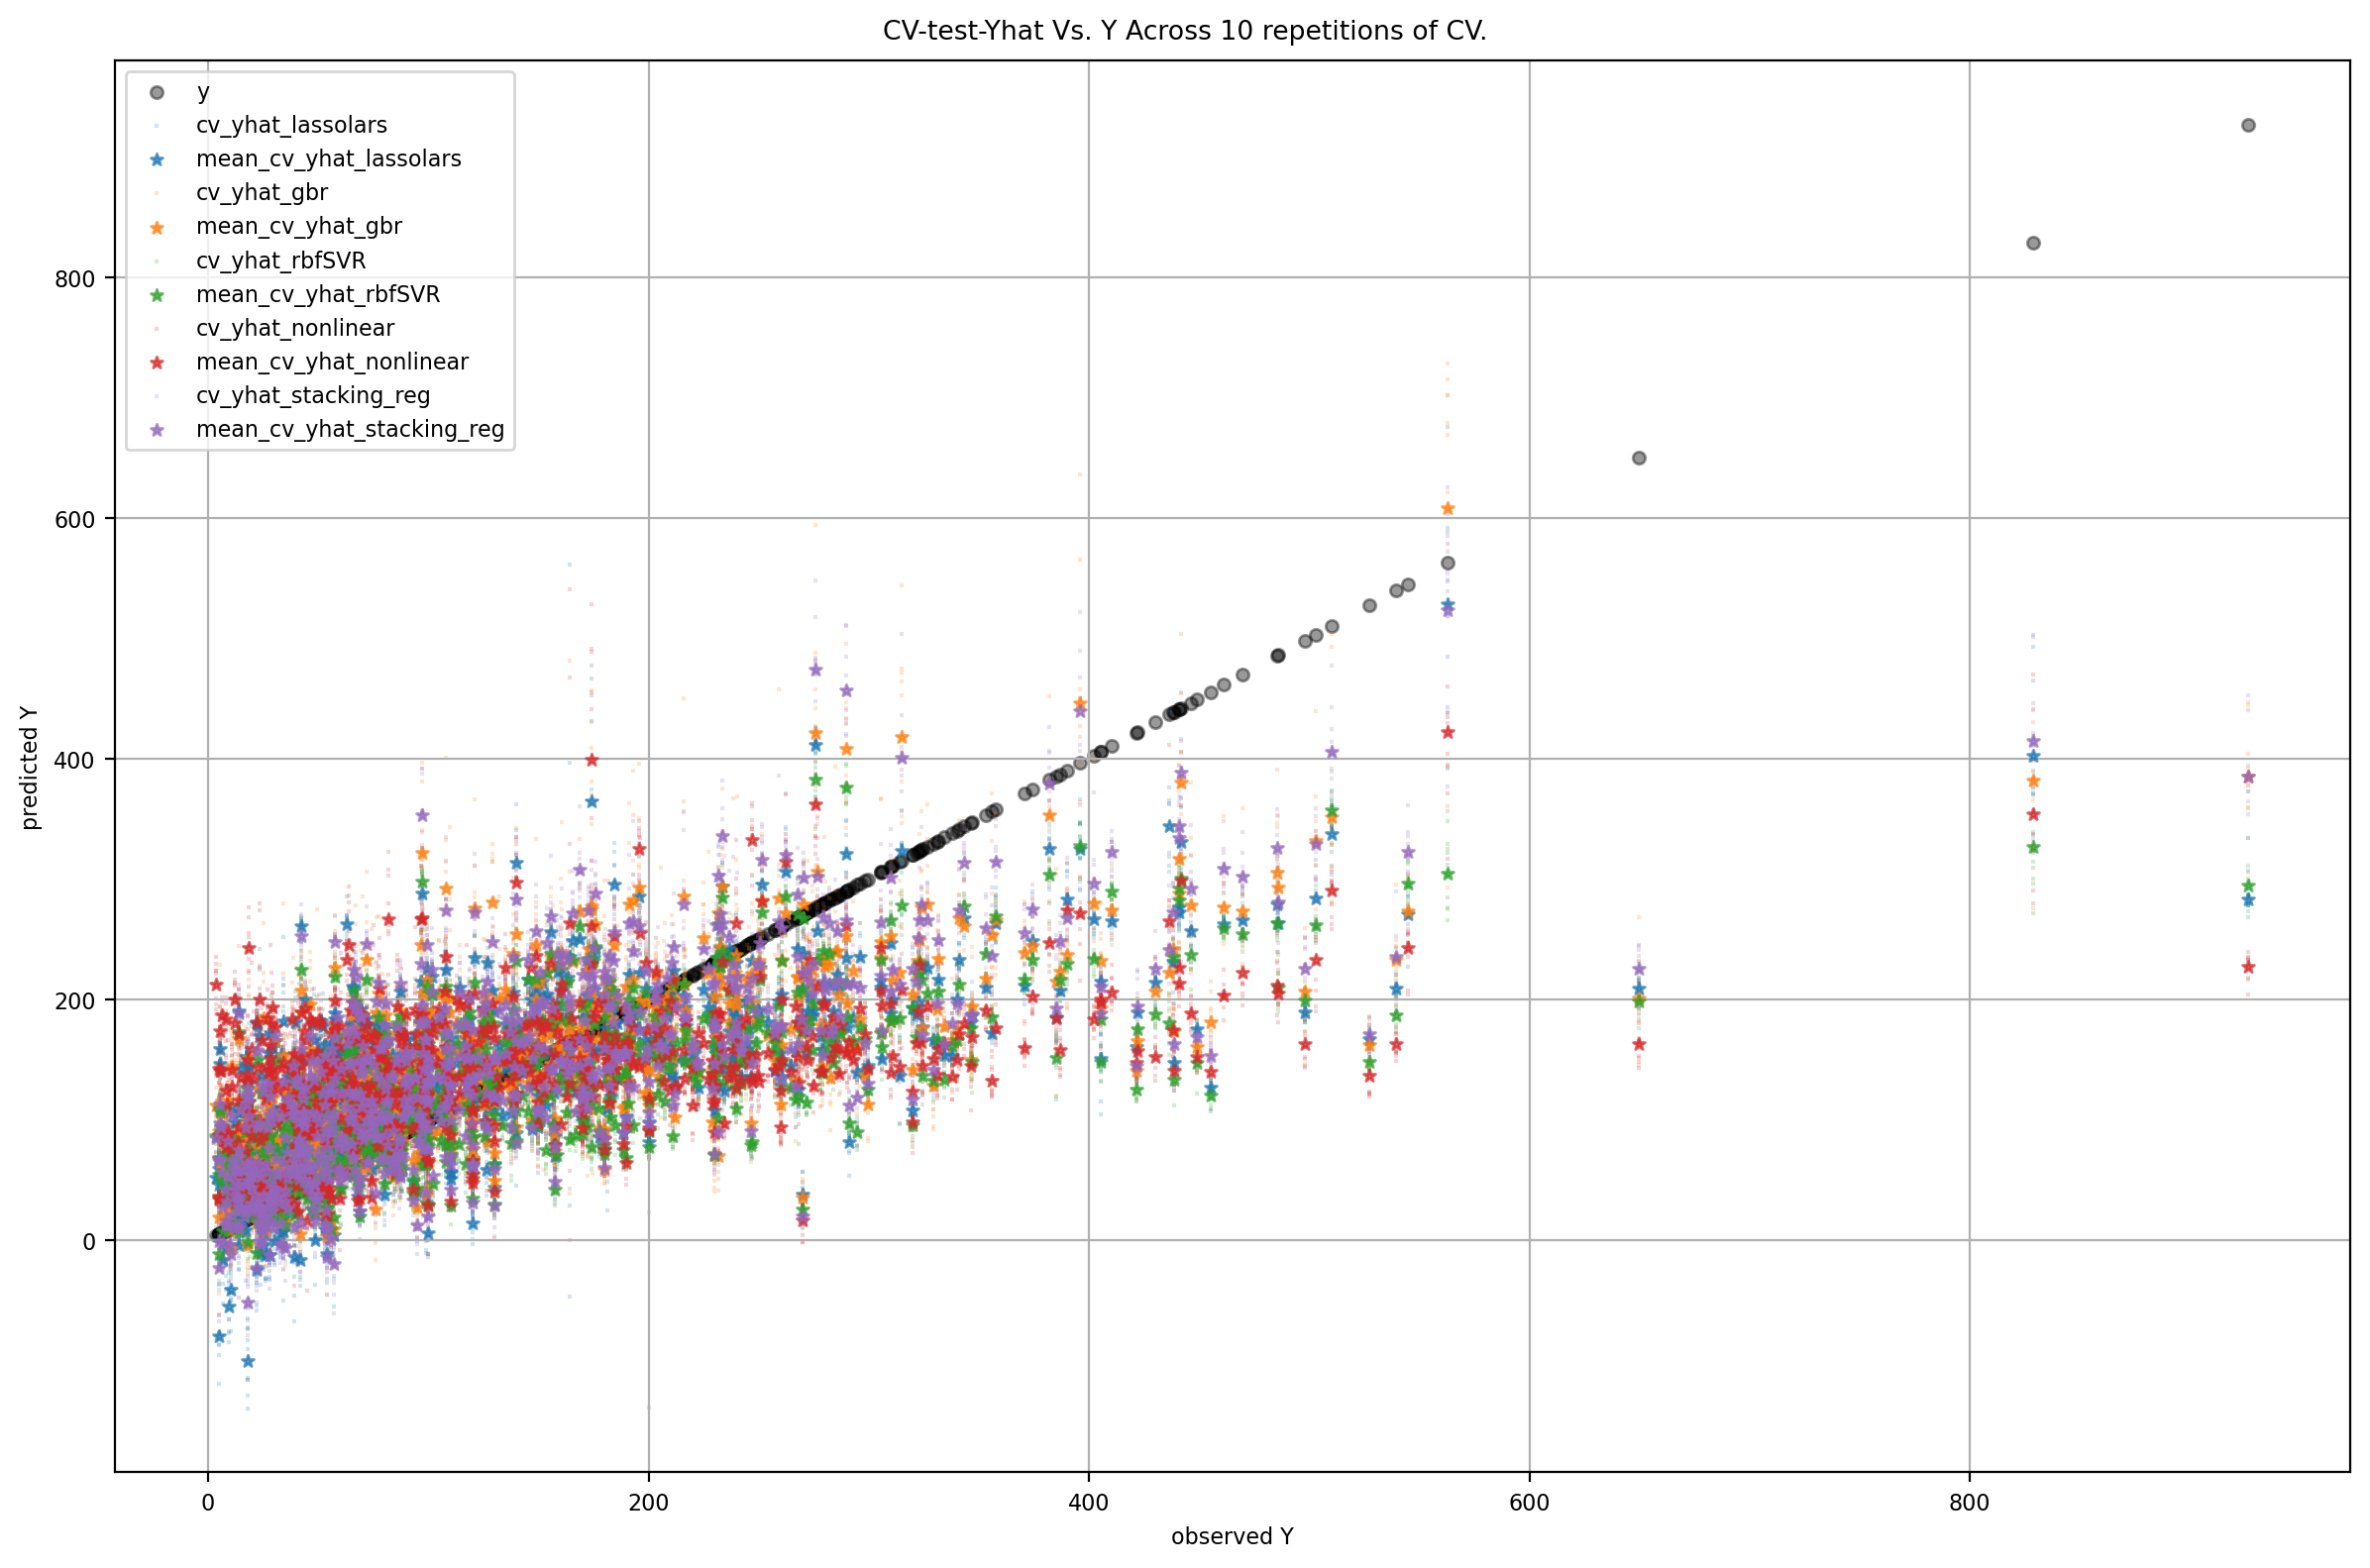

In [30]:
plotter.plotCVYhatVsY(single_plot=True,include_all_cv=True)

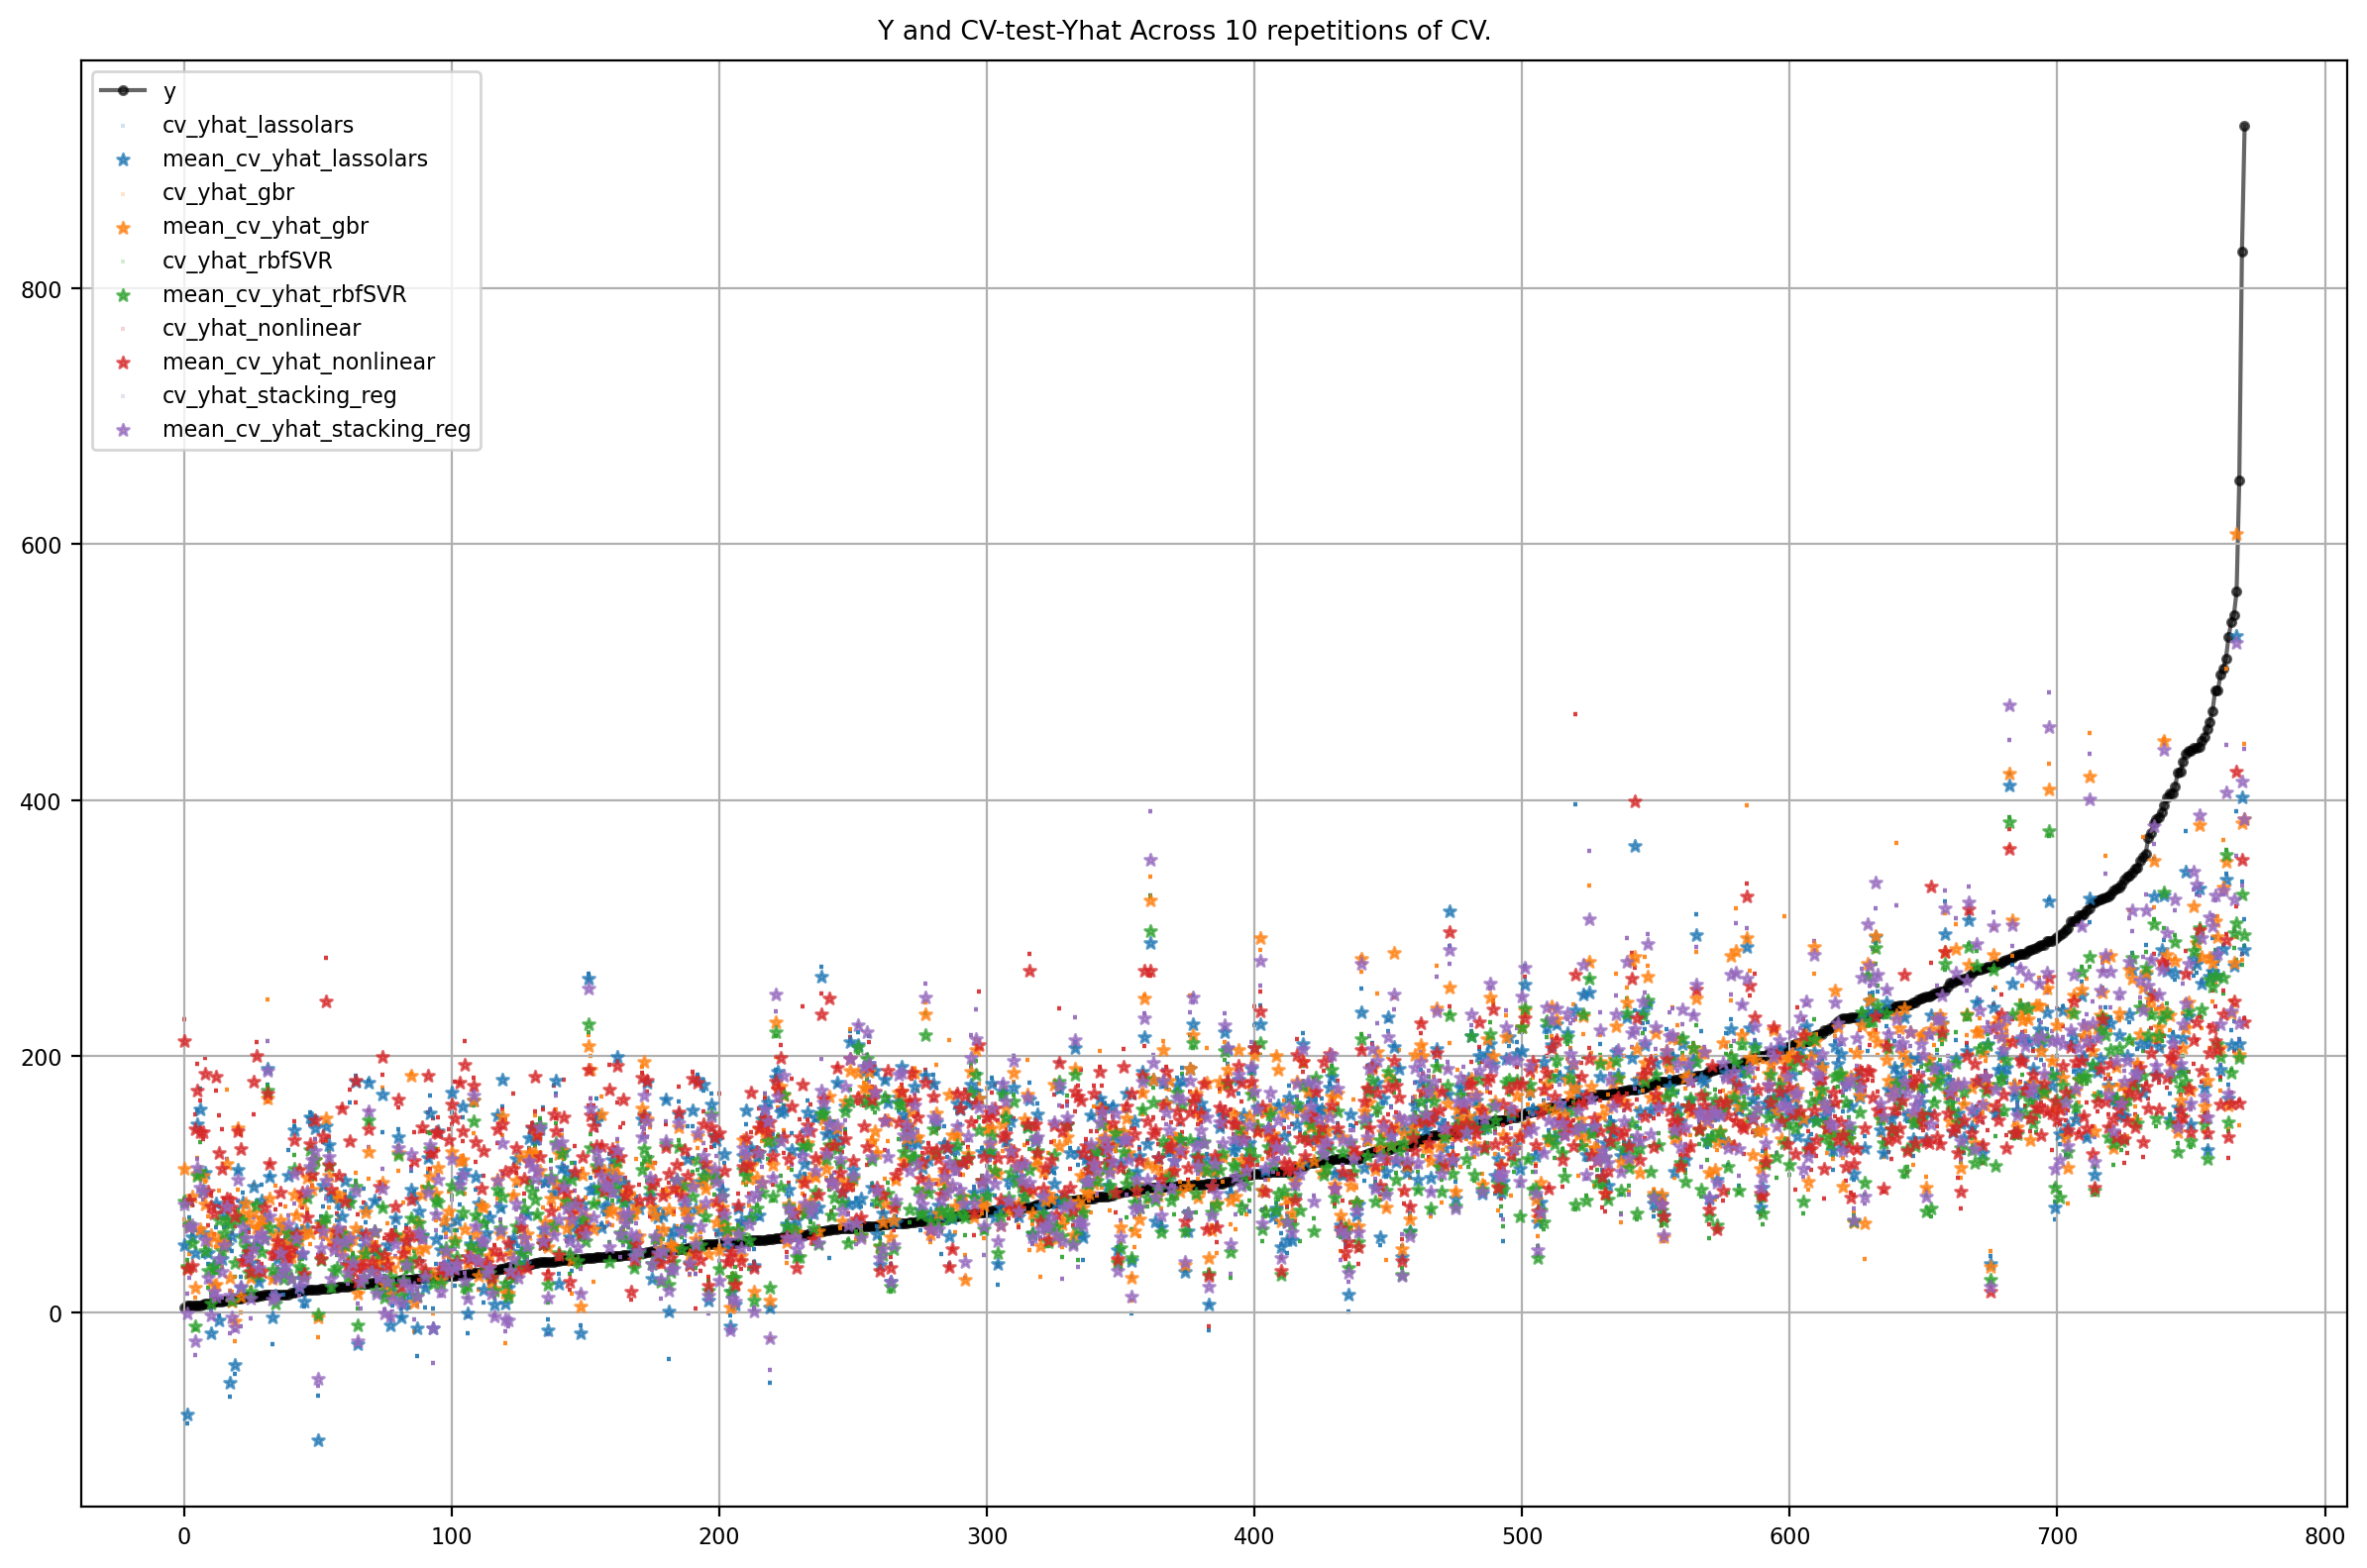

In [31]:
plotter.plotCVYhat(single_plot=True,include_all_cv=True) #add option to use original row order instead of sort

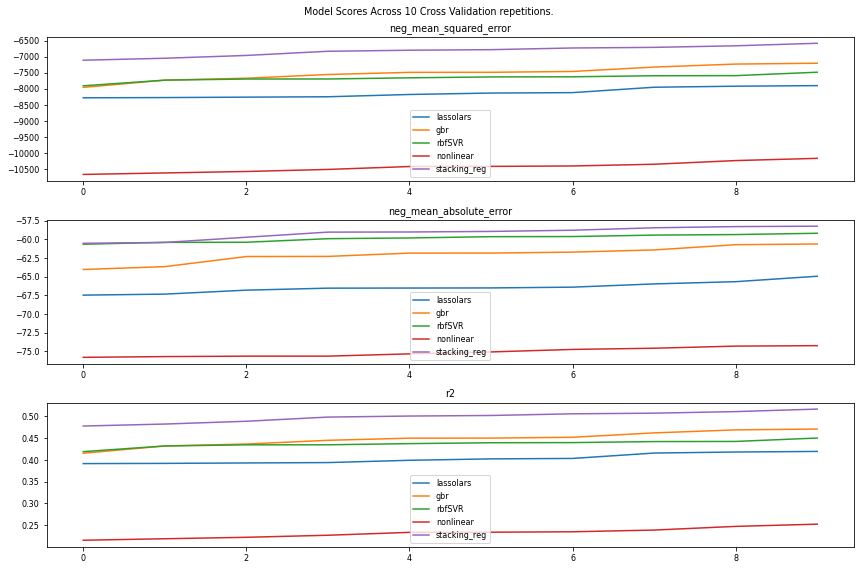

In [32]:
plotter.plotCVScores(sort=1)

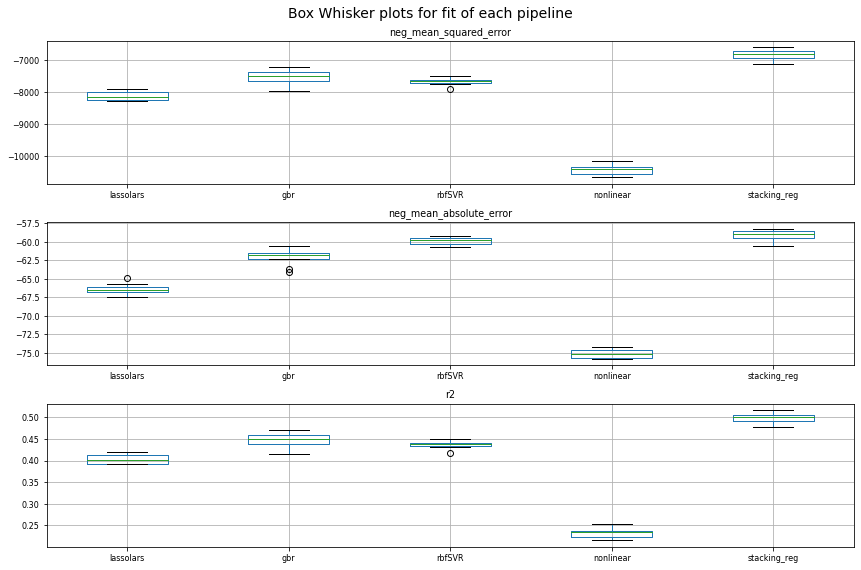

In [33]:
plotter.plotBoxWhiskerCVScores()

# VB web
### Small Data Procedure
---
**The Stacking Regressor is selected**

#### task 2: train the final model

In [34]:
vbhelper.refitPredictiveModels(selected_models=['stacking_reg'])

predictive models loaded from stash/predictive_model-440b67c5c80a529ac01daadb3cc5ef12.pkl


### Prediction
Finally we are ready to use the predictive model that we just estimated.


In [35]:
vbhelper.predictandSave(X_predict)

prediction results saved to project_prediction_results.json


In [36]:
#mimicking the front end-back end data transfer...
with open('project_prediction_results.json', 'r') as f:
    project_prediction_results=json.load(f)
plotter.setPredictData(project_prediction_results)

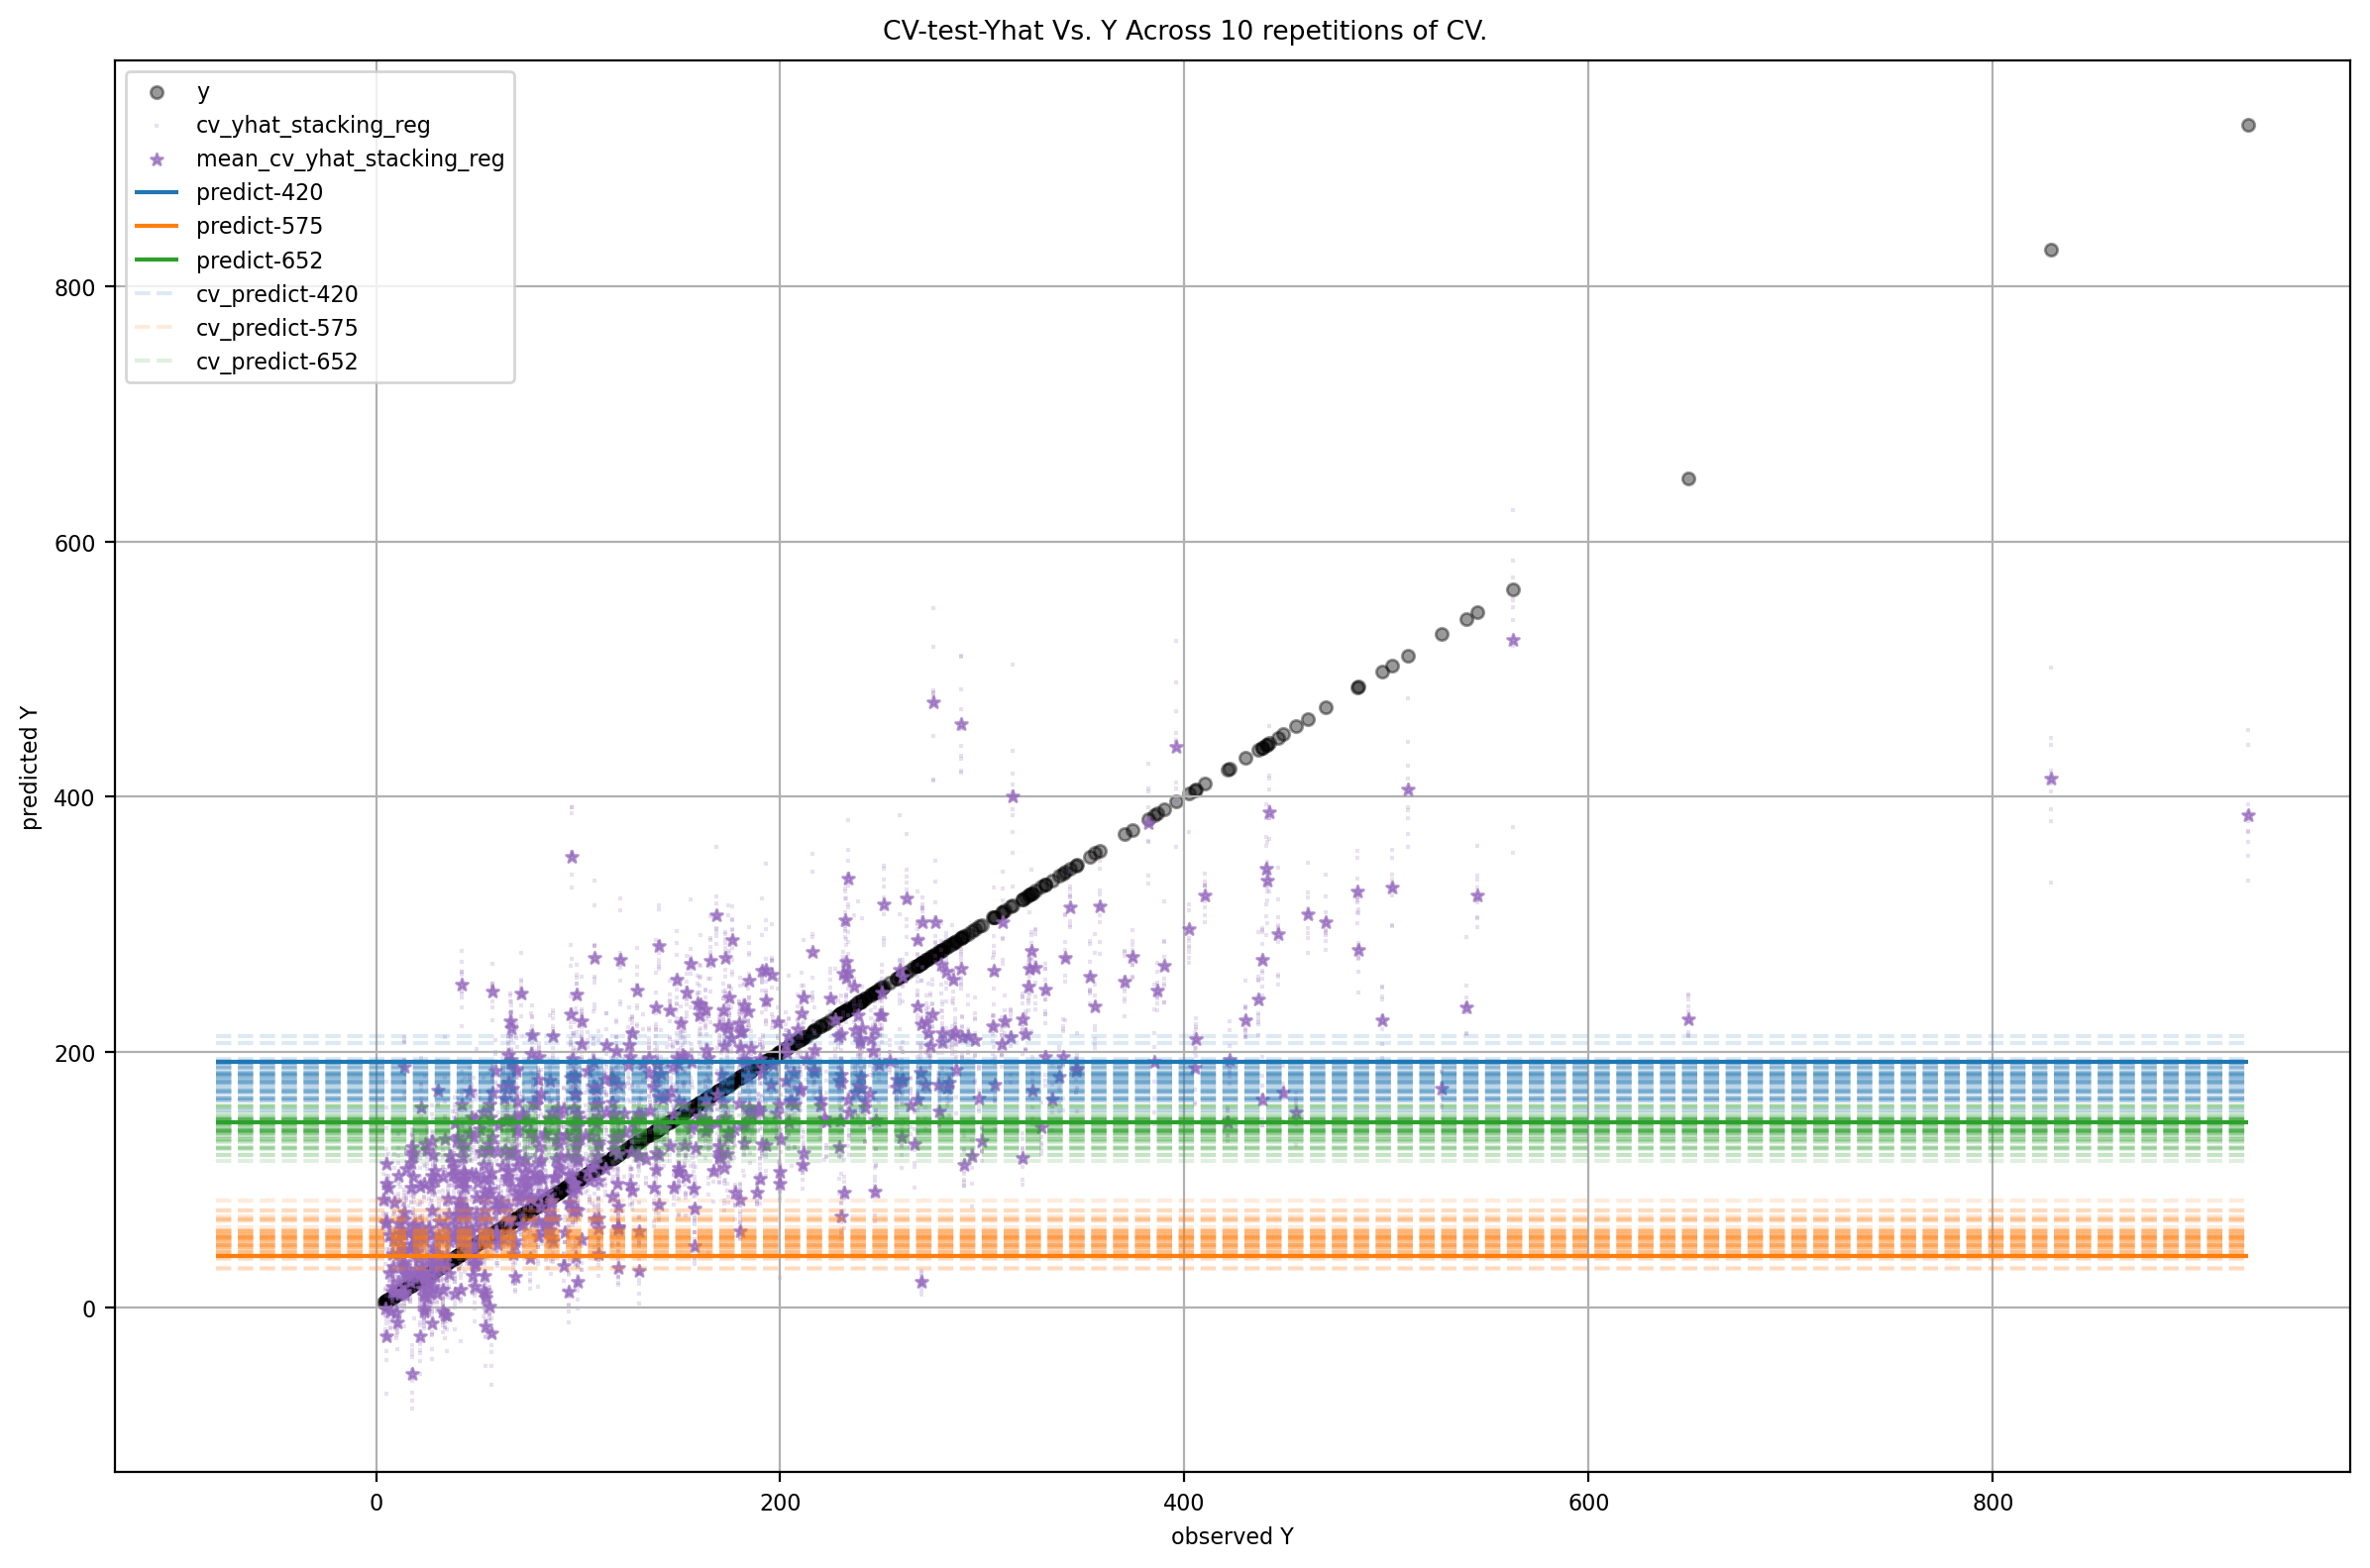

In [37]:
p_kwargs=dict(single_plot=True, include_all_cv=True,
              ypredict=True,cv_ypredict=True,estimators='selected')
plotter.plotCVYhatVsY(**p_kwargs)

#### And redraw the plots with the known values of y as vertical lines

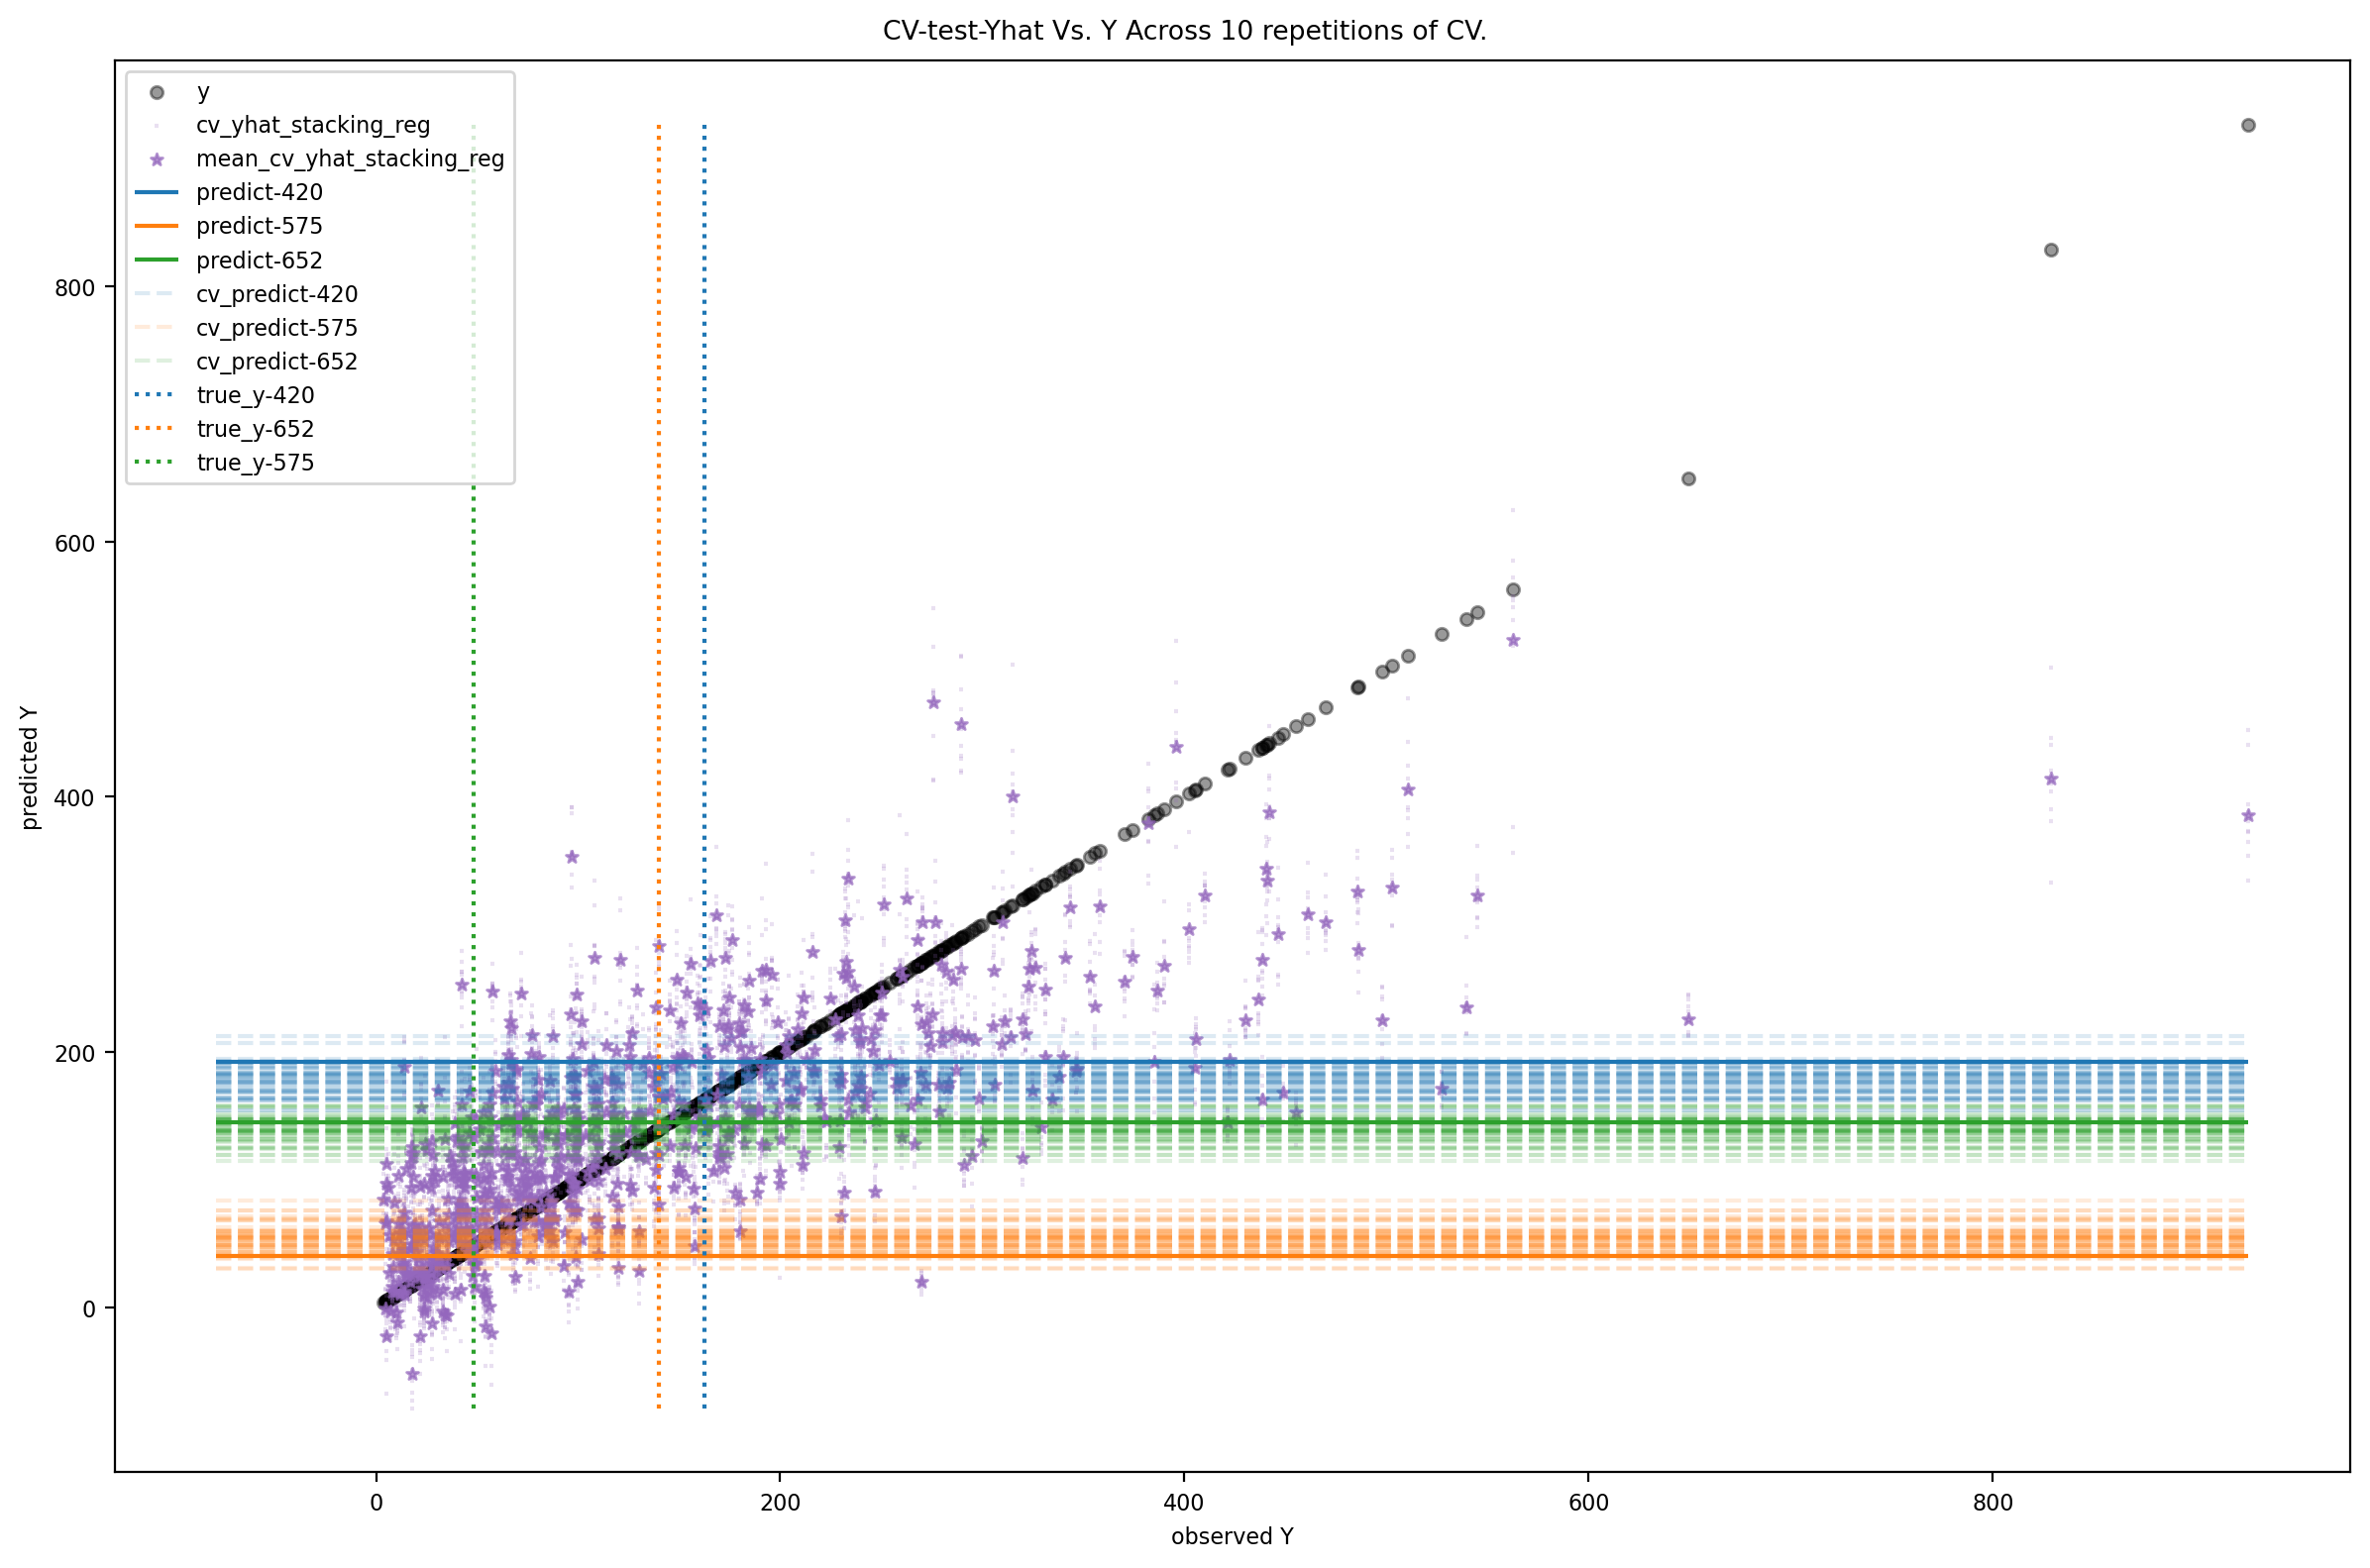

In [38]:
plotter.plotCVYhatVsY(**p_kwargs,true_y=y_predict)

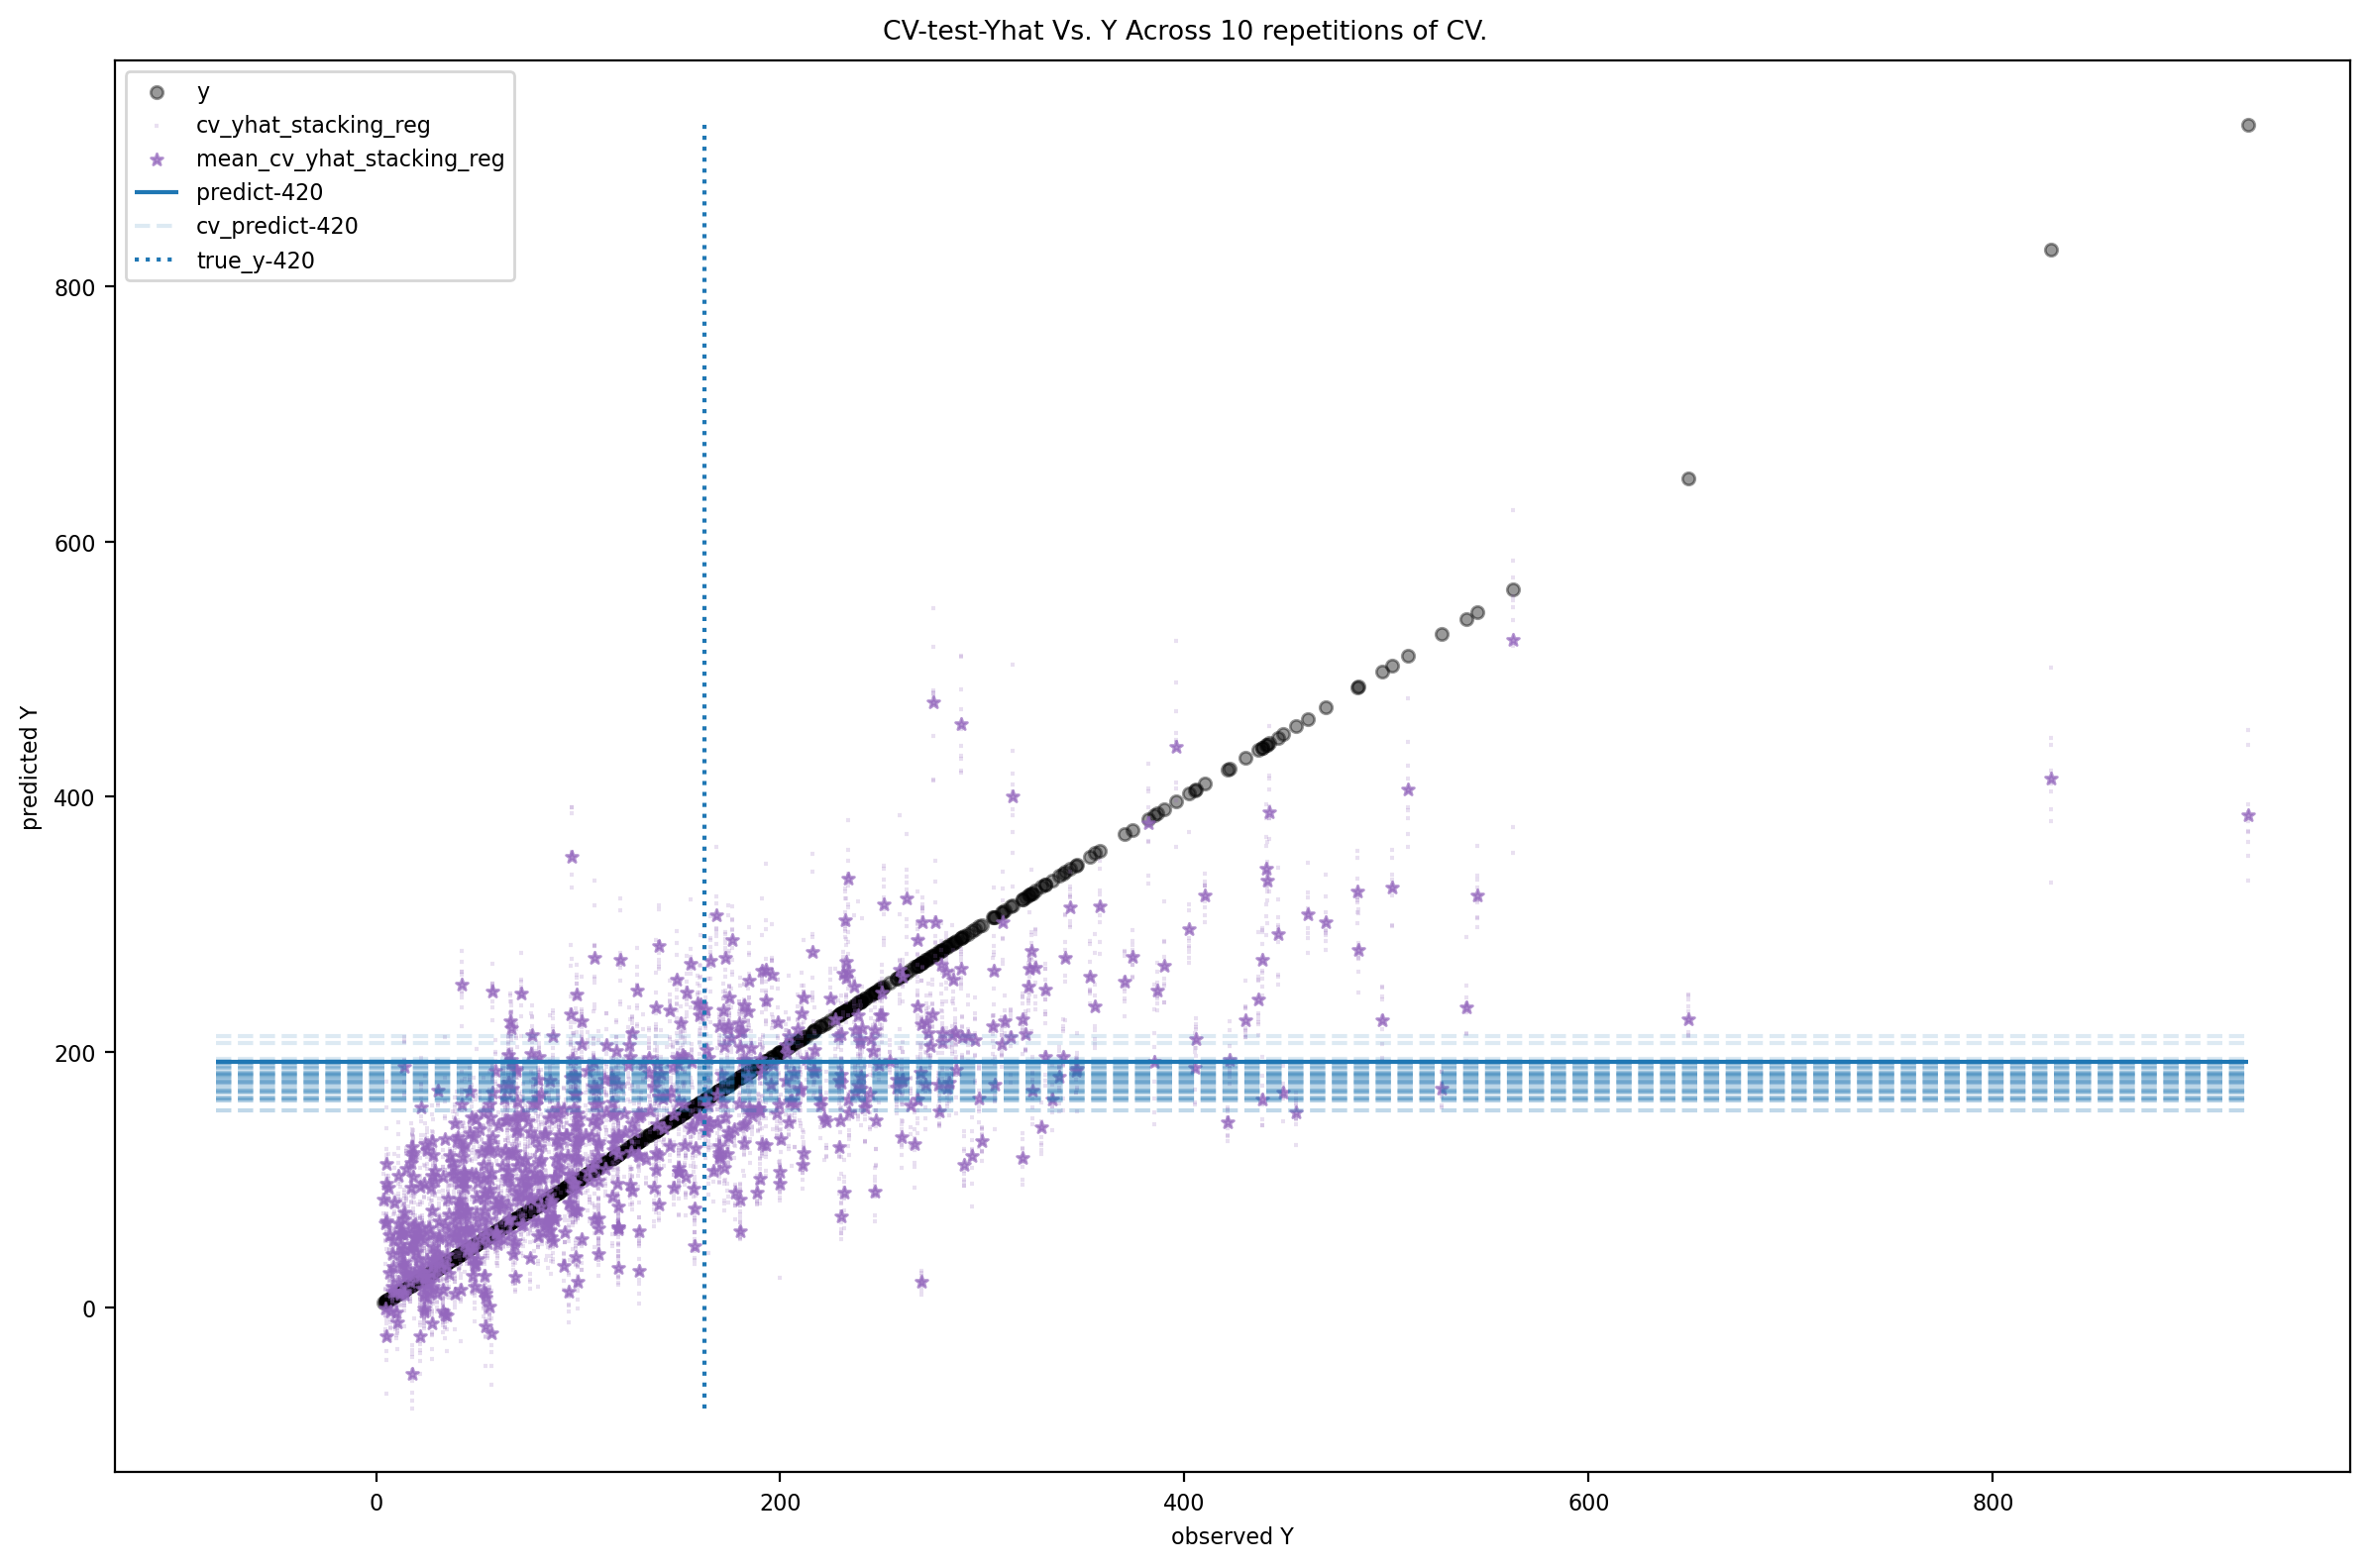

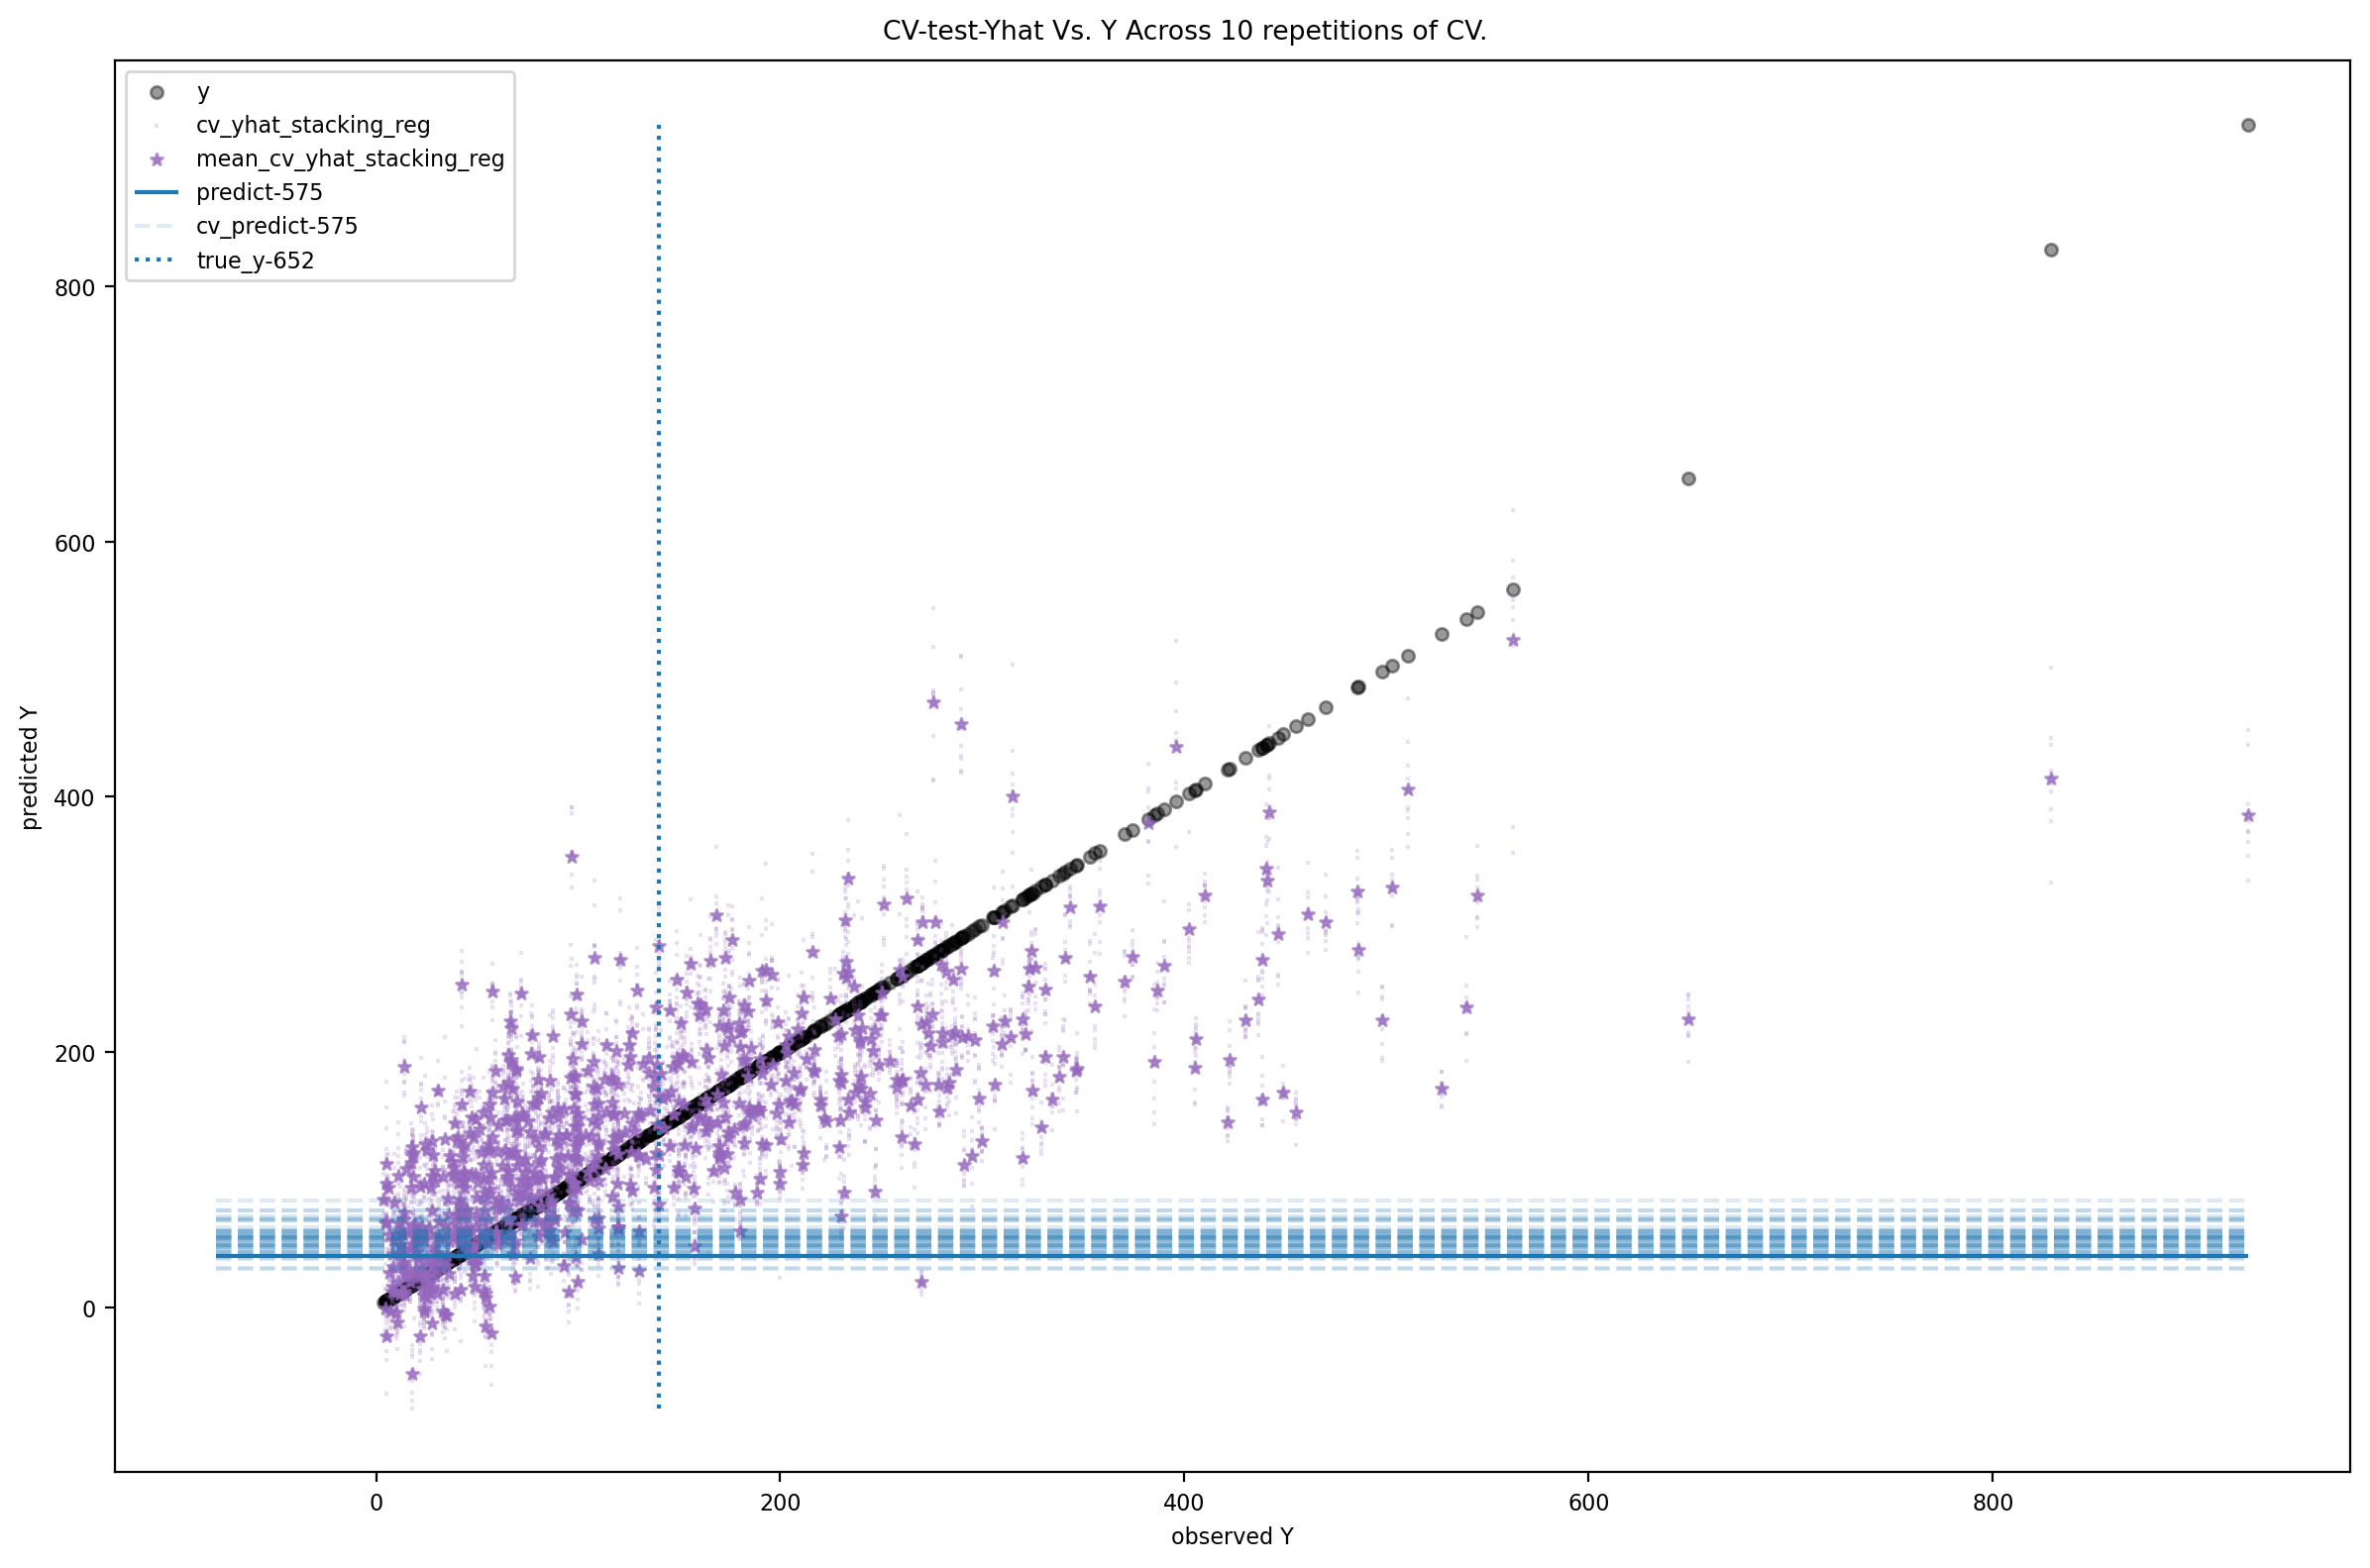

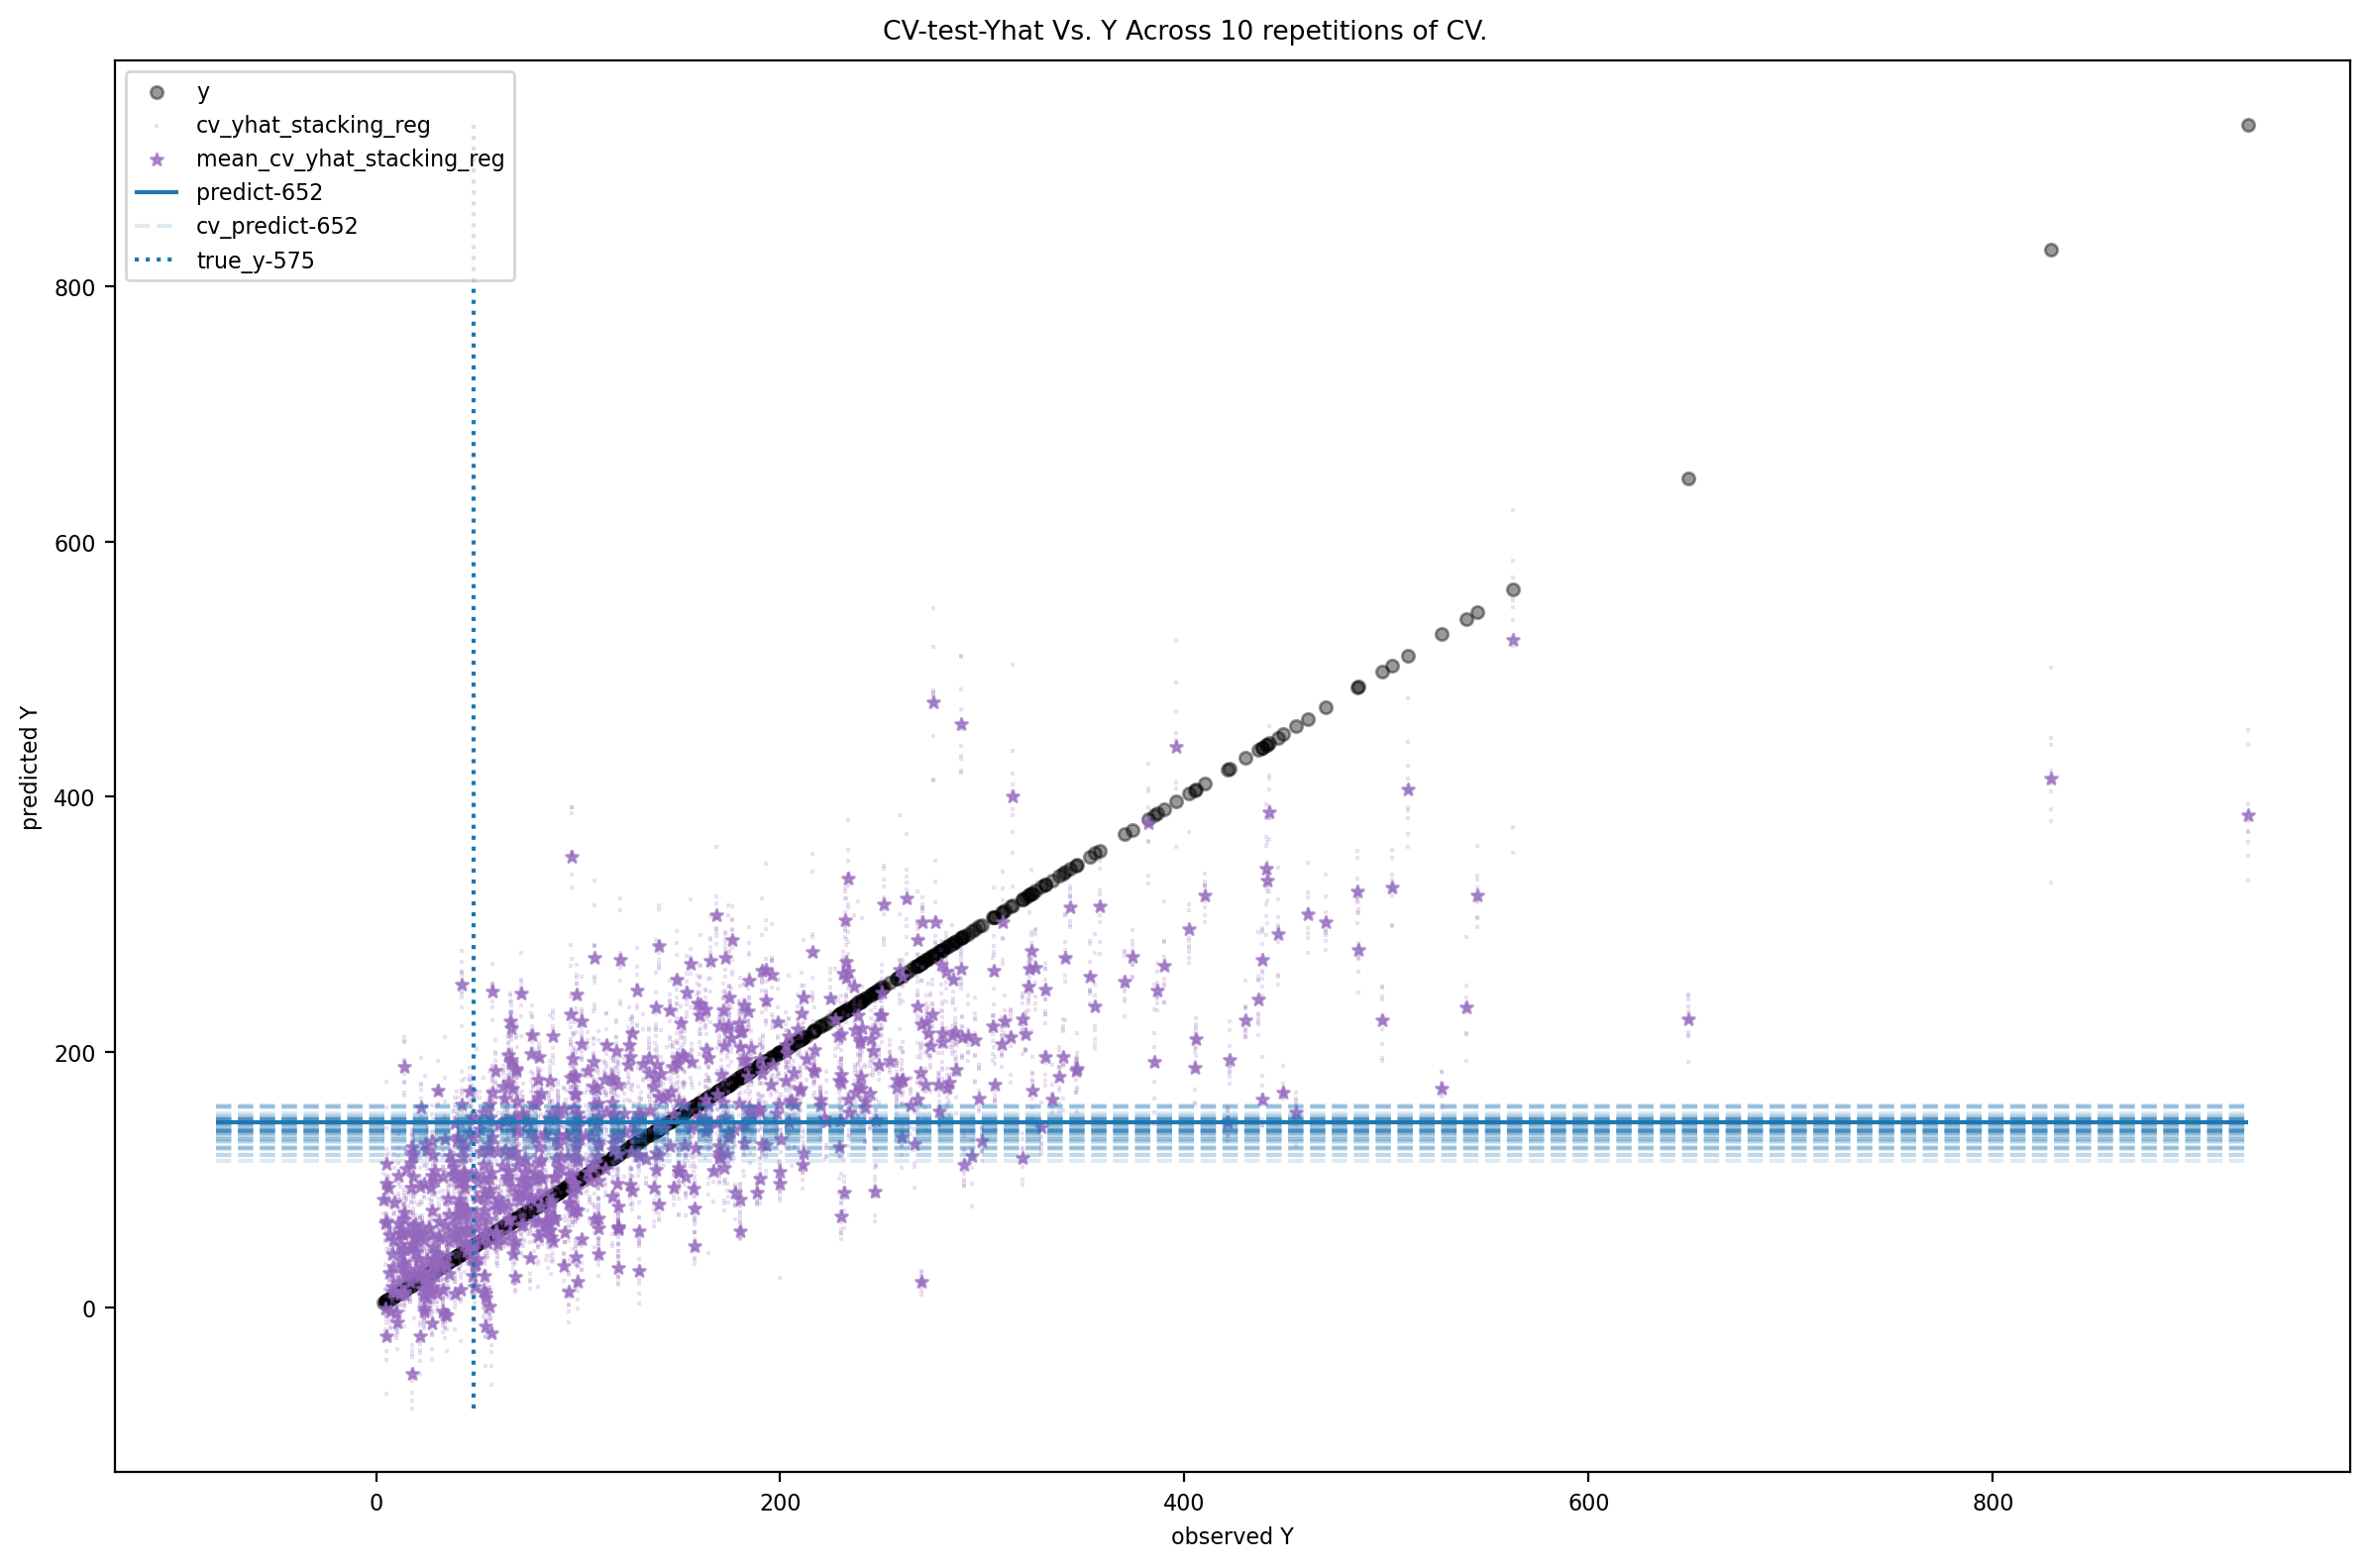

In [39]:
plotters=[VBPlotter() for _ in range(predict_n)]
for p in plotters: p.setData(cv_results_and_scores)
for i in range(predict_n): plotters[i].setPredictData(project_prediction_results,select_row=i)
for i in range(predict_n): plotters[i].plotCVYhatVsY(**p_kwargs,true_y=y_predict.iloc[i:i+1])